<a href="https://colab.research.google.com/github/vendidad/Kaggle/blob/master/Earthquake_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LANL Earthquake Prediction - kaggle

The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each seg_id in the test folder, you should predict a single time_to_failure corresponding to the time between the last row of the segment and the next laboratory earthquake.

<font size=2>

  * The input is a chunk of 0.0375 seconds of seismic data (ordered in time), which is recorded at 4MHz, hence 150'000 data points, and the output is time remaining until the following lab earthquake, in seconds.

* The seismic data is recorded using a piezoceramic sensor, which outputs a voltage upon deformation by incoming seismic waves. The seismic data of the input is this recorded voltage, in integers.

* Both the training and the testing set come from the same experiment. There is no overlap between the training and testing sets, that are contiguous in time.

* Time to failure is based on a measure of fault strength (shear stress, not part of the data for the competition). When a labquake occurs this stress drops unambiguously.

* The data is recorded in bins of 4096 samples. Withing those bins seismic data is recorded at 4MHz, but there is a 12 microseconds gap between each bin, an artifact of the recording device.
  
</font>

_The work below references contributions from various individuals posting on kaggle & elsewhere._<br>

<font size=1>
<a href="https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples" target ="_blank">Earthquakes FE. More features and samples</a>  by Andrew Lukyanenko,&nbsp
<a href="https://www.kaggle.com/pedrormarques/fft-experiment" target ="_blank">fft experiment</a>  by Pedro Marques,&nbsp 
<a href="https://www.kaggle.com/aperezhortal/eda-on-the-frequency-domain-fft" target ="_blank">EDA on the frequency domain (FFT)</a>  by Andres Perez,&nbsp
<a href="https://www.kaggle.com/vettejeep/masters-final-project-eda" target ="_blank">Masters Final Project: EDA</a>  by Vettejeep,&nbsp
<a href="https://www.kaggle.com/allunia/shaking-earth" target ="_blank">Shaking Earth</a>  by Allunia<br>
</font>

#Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Garbage Collection

In [0]:
import gc
import psutil

print("available RAM:", psutil.virtual_memory())
gc.collect()
print("available RAM:", psutil.virtual_memory())

available RAM: svmem(total=13655322624, available=12923748352, percent=5.4, used=446210048, free=11374276608, active=574787584, inactive=1437679616, buffers=68546560, cached=1766289408, shared=929792, slab=146247680)
available RAM: svmem(total=13655322624, available=12923596800, percent=5.4, used=446287872, free=11374022656, active=575000576, inactive=1437732864, buffers=68546560, cached=1766465536, shared=929792, slab=146284544)


# Dependencies

###Install Dependencies

In [0]:
# !pip install numpy==1.16.2
!pip install scipy==1.2.1
# !pip install python_speech_features 
!pip install catboost

### Import Dependencies

In [0]:
from google.colab import files
import gc
import os
from warnings import simplefilter
import pickle

import pandas as pd
import numpy as np
from scipy import stats
import scipy.signal as sg
import statsmodels.formula.api as sm
import librosa, librosa.display

import matplotlib.pyplot as plt
import seaborn as sb


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Scale Data Function

In [0]:
def scale(scaler, data):
  from sklearn.preprocessing import StandardScaler, MinMaxScaler
  
  if (scaler == 'standard'):
    std_scaler = StandardScaler()
    return (std_scaler.fit_transform(data))
  elif (scaler == 'minmax'):
    minmax_scaler = MinMaxScaler(feature_range=(-1,1))
    return (minmax_scaler.fit_transform(data))

#Import Dataset from Kaggle

In [0]:
#to access kaggle datasets
!pip install kaggle

# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [0]:
#list competitions
!kaggle competitions list

In [0]:
#download earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

In [0]:
#unzip training data for usage
!ls
# !unzip train.csv.zip -d '/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/'
!unzip train.csv.zip
# !unzip test.zip
!ls

#Load full dataset

In [0]:
import pickle
import gc

with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train.pkl', 'rb') as pklfile:
  train_full = pickle.load(pklfile)
  
print (f'train_full => {train_full.shape}')

gc.collect()

train_full => (629145480, 2)


0

# EDA

In [0]:
ad = train_full[:300000000:100]['acoustic_data']
ttf = train_full[:300000000:100]['time_to_failure']

# ac = train_full[5650000:5660000:100]['acoustic_data']
# ttf = train_full[5650000:5660000:100]['time_to_failure']


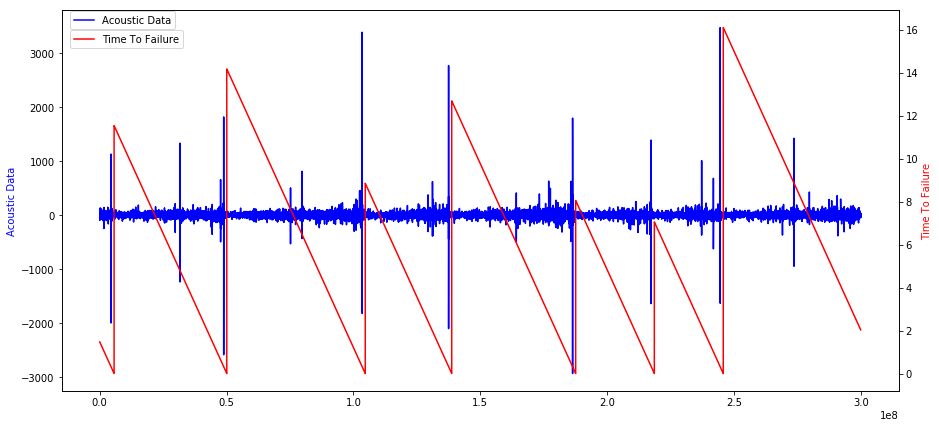

4401

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(ad, color-='b')
ax1.set_ylabel('Acoustic Data', color='b')
plt.legend(['Acoustic Data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(ttf, color='r')
ax2.set_ylabel('Time To Failure', color='r')
plt.legend(['Time To Failure'], loc=(0.01, 0.9))

plt.show()
gc.collect()

In [0]:
ad_scaled = scale('minmax',ad.values.reshape(-1,1))

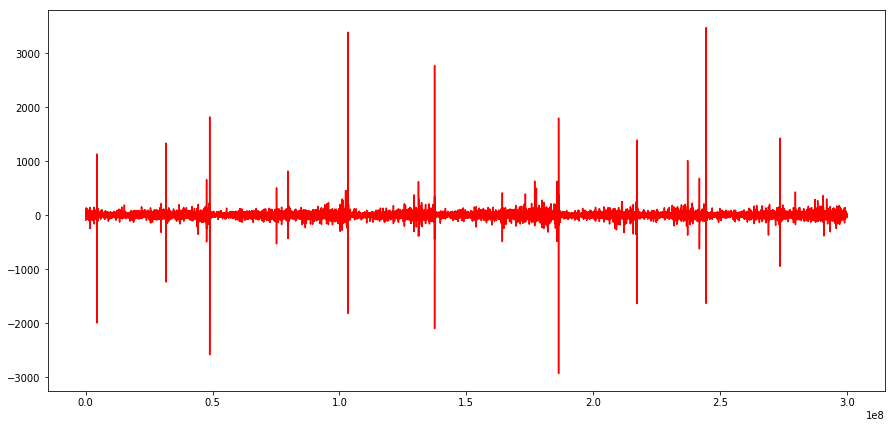

2304

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,7))
# plt.plot(ad, color='b')
plt.plot(ad, color='r')
plt.show()
gc.collect()

In [0]:
def rolling_envelope(data, win):
  ma = ad.rolling(window=win).mean()
  std = ad.rolling(window=win).std()
  ub = ma + std*2
  lb = ma - std*2
  return (ub, lb)

(ub, lb) = rolling_envelope(ad, 150)

def plt_boll(ad, ttf, ub, lb):
  fig, ax1 = plt.subplots(figsize=(15,7))
  plt.plot(ad, color='b')
  ax1.set_ylabel('Acoustic Data', color='b')
  plt.legend(['Acoustic Data'], loc=(0.01, 0.95))
  plt.plot(ub, color='g')
  plt.plot(lb, color='g')
  ax2 = ax1.twinx()
  plt.plot(ttf, color='r')
  ax1.set_ylabel('Time To Failure', color='r')
  plt.legend(['Time To Failure'], loc=(0.01, 0.9))
  plt.show()

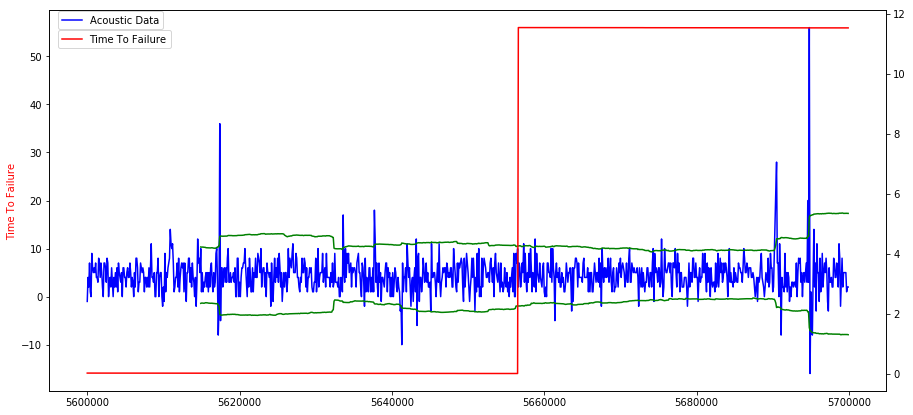

4322

In [0]:
ad = train_full[5600000:5700000:100]['acoustic_data']
ttf = train_full[5600000:5700000:100]['time_to_failure']

(ub, lb) = rolling_envelope(ad, 150)
plt_boll (ad, ttf, ub, lb)
gc.collect()

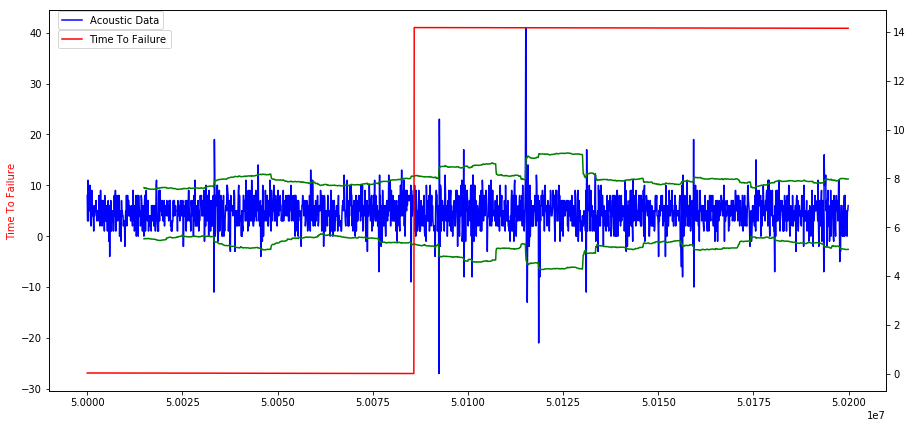

4626

In [0]:
ad = train_full[50000000:50200000:100]['acoustic_data']
ttf = train_full[50000000:50200000:100]['time_to_failure']

(ub, lb) = rolling_envelope(ad, 150)
plt_boll (ad, ttf, ub, lb)
gc.collect()

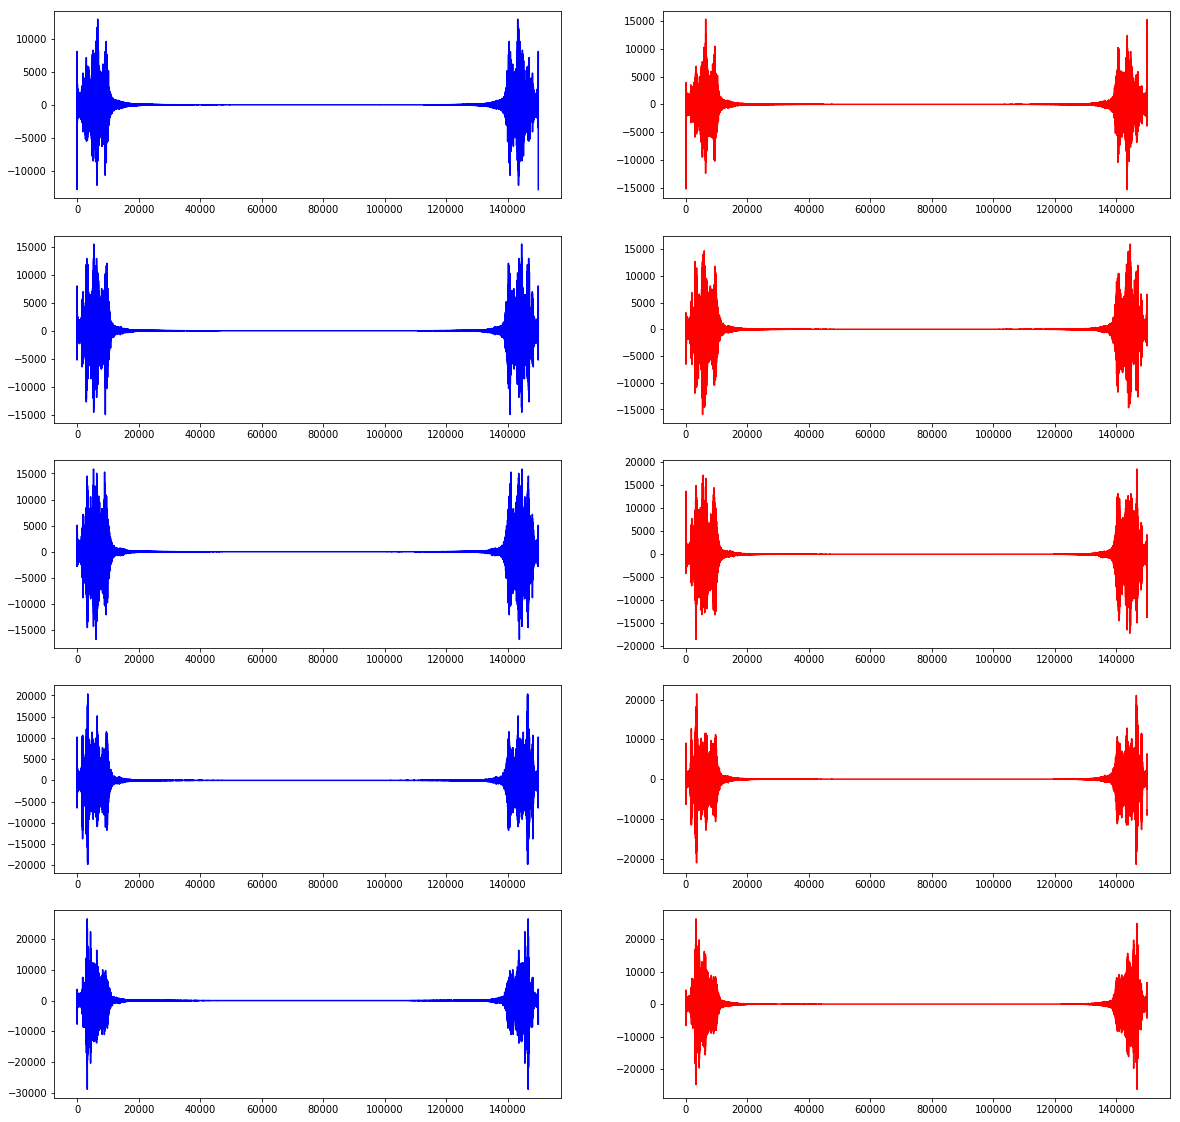

In [0]:
# Majority of the signal ifnormation appears to be between 0-20000 & 130000-150000 
plt.figure(figsize=(20,20))
n = 1
for i in range (0,len(train_full),150000):
  data = train_full['acoustic_data'][i:i+150000]
  data = data - np.mean(data)
  b, a = sg.butter(3, 0.1, 'low')
  data = sg.lfilter(b, a, data)
  fft = np.fft.fft(data)
  fft_r = fft.real
  fft_i = fft.imag
#   fft_a = np.abs(fft)
  plt.subplot(5,2,n)
#   plt.plot(fft_a)
  plt.plot(fft_r, 'b')
  n+=1
  plt.subplot(5,2,n)
  plt.plot(fft_i, 'r')
  n+=1
  if (n>10): break
plt.show()

In [0]:
gc.collect()

0

In [0]:
librosa.get_duration(t.values.astype('float32')), librosa.get_duration(t1.values.astype('float32'))

(9.070294784580499e-05, 9.070294784580499e-05)

In [0]:
type(t['acoustic_data'].values.astype('float32'))

numpy.ndarray

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


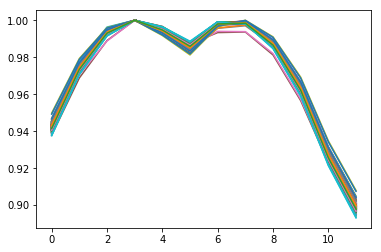

In [0]:
c = librosa.feature.chroma_stft(y=t['acoustic_data'].values.astype('float32'), sr=4e6)

plt.plot(c)
plt.show()

In [0]:
ft = np.fft.fft(t['acoustic_data'].values.astype('float32'), n=30000)
ft1 = np.fft.fft(t['acoustic_data'].values.astype('float32'))

In [0]:
t = train_full[:10000000:100]
t = train_full[10000000:20000000:100]
ft1 = np.fft.fft(t['acoustic_data'].values.astype('float32'))
n = t['acoustic_data'].values.size
timestep = 0.0375/150000
freq = np.fft.fftfreq(n, d=timestep)
freq

array([   0.,   40.,   80., ..., -120.,  -80.,  -40.])

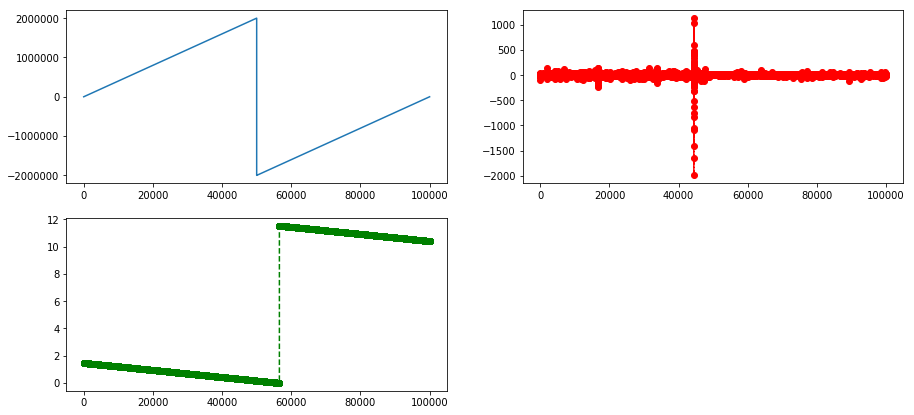

In [0]:
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(freq)
plt.subplot(2,2,2)
plt.plot(t['acoustic_data'].values,'ro--')
plt.subplot(2,2,3)
plt.plot(t['time_to_failure'].values,'go--')
plt.show()

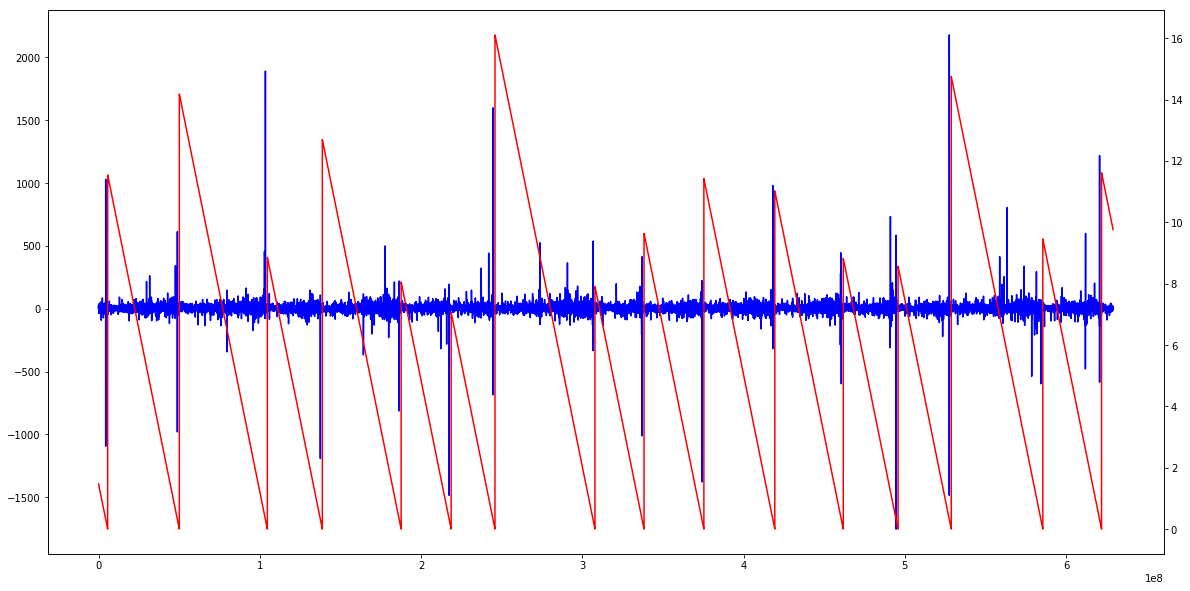

In [0]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(1,1,1)
ax1.plot(train_full['acoustic_data'][::1000], 'b')
ax2 = ax1.twinx()
ax2.plot(train_full['time_to_failure'][::1000], 'r')

plt.show()

In [0]:
librosa.feature.mfcc(data.values.astype('float32'), sr=4e6)

In [0]:
x = train_full['acoustic_data'][0:50000000].abs() > 500

##### https://medium.com/@sdoshi579/classification-of-music-into-different-genres-using-keras-82ab5339efe0
##### https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d

In [0]:
s1 = train_full['acoustic_data'][:150000]
s2 = train_full['acoustic_data'][150000:300000]
sr=4e6

In [0]:
zero_crossings1 = librosa.zero_crossings(s1.values.astype('float32'), pad=False)
zero_crossings2 = librosa.zero_crossings(s2.values.astype('float32'), pad=False)

In [0]:
print(sum(zero_crossings1))
print(sum(zero_crossings2))

11112
12008


In [0]:
spectral_centroids1 = librosa.feature.spectral_centroid(s1.values.astype('float32'), sr=sr)[0]
np.mean(spectral_centroids1)

675299.9943783223

In [0]:
# chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
# rmse = librosa.feature.rmse(y=y)
# spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
# spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
# rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
# zcr = librosa.feature.zero_crossing_rate(y)

In [0]:
chroma_stft = librosa.feature.chroma_stft(y=s1.values.astype('float32'))

In [0]:
np.mean(chroma_stft)

0.5757795944145826

In [0]:
mfcc = librosa.feature.mfcc(s1.values.astype('float32'))

In [0]:
mfcc_mean = mfcc.mean(axis=1)
mfcc_mean
  

array([ 3.35479553e+02,  2.99301670e+01, -2.60597931e+01, -1.55906562e+01,
       -9.09524081e+00,  8.05539566e+00,  2.23116992e+00,  6.10149120e-02,
       -2.16885628e+00,  3.41836274e+00,  4.98848133e+00,  4.02713070e+00,
       -1.27900590e+00, -6.22596821e-01,  4.88750961e+00,  9.30963107e+00,
        5.51279024e+00,  6.48931181e-01,  7.71711300e-01,  4.14070807e+00])

In [0]:
mfcc_mean = mfcc.mean(axis=1)
  for mean in mfcc_mean:
    strain.append(mean)

In [0]:
for e in mfcc:
  print (np.mean(e))
  

335.47955286913736
29.93016703427211
-26.05979313655785
-15.590656218489885
-9.095240808044457
8.055395658839243
2.231169920332938
0.06101491196736229
-2.168856279951761
3.418362743639484
4.9884813315312675
4.027130697453281
-1.2790059006224745
-0.6225968212757136
4.887509612096374
9.309631070810049
5.512790236525506
0.6489311814919125
0.7717112995366777
4.140708065084331


# Train dataset

### Feature Engineering

In [0]:
from sklearn.linear_model import LinearRegression
import librosa, librosa.display

def fft5(data):
  strain = []
  data = data - np.mean(data)
  b, a = sg.butter(3, 0.1, 'low')
  data = sg.lfilter(b, a, data)
  fft = np.fft.fft(data)
  fft_abs = np.abs(fft)
  strain.append(fft_abs.mean())
  strain.append(fft_abs.std())
  strain.append(fft_abs.min())
  strain.append(fft_abs.max())
  strain.append(stats.kurtosis(fft_abs))
  strain.append(stats.skew(fft_abs))
  strain.append(np.quantile(fft_abs, 0.01))
  strain.append(np.quantile(fft_abs, 0.05))
  strain.append(np.quantile(fft_abs, 0.95))
  strain.append(np.quantile(fft_abs, 0.99))
  return pd.Series(strain)

def fft4(data):
  strain = []
  data = data - np.mean(data)
  b, a = sg.butter(3, 0.1, 'low')
  data = sg.lfilter(b, a, data)
  fft = np.fft.fft(data)
  fft_r = fft.real
  fft_i = fft.imag
  
  fft_r_top = fft_r[0:int(len(fft_r)*0.14)]
  fft_r_bottom = fft_r[len(fft_r)-int(len(fft_r)*0.14):]
  strain.append(fft_r_top.mean())
  strain.append(fft_r_top.std())
  strain.append(fft_r_top.min())
  strain.append(fft_r_top.max())
  strain.append(stats.kurtosis(fft_r_top))
  strain.append(stats.skew(fft_r_top))
  strain.append(np.quantile(fft_r_top, 0.01))
  strain.append(np.quantile(fft_r_top, 0.05))
  strain.append(np.quantile(fft_r_top, 0.95))
  strain.append(np.quantile(fft_r_top, 0.99))
  strain.append(fft_r_bottom.mean())
  strain.append(fft_r_bottom.std())
  strain.append(fft_r_bottom.min())
  strain.append(fft_r_bottom.max())
  strain.append(stats.kurtosis(fft_r_bottom))
  strain.append(stats.skew(fft_r_bottom))
  strain.append(np.quantile(fft_r_bottom, 0.01))
  strain.append(np.quantile(fft_r_bottom, 0.05))
  strain.append(np.quantile(fft_r_bottom, 0.95))
  strain.append(np.quantile(fft_r_bottom, 0.99))
  
  fft_i_top = fft_i[0:int(len(fft_i)*0.14)]
  fft_i_bottom = fft_i[len(fft_i)-int(len(fft_i)*0.14):]
  strain.append(fft_i_top.mean())
  strain.append(fft_i_top.std())
  strain.append(fft_i_top.min())
  strain.append(fft_i_top.max())
  strain.append(stats.kurtosis(fft_i_top))
  strain.append(stats.skew(fft_i_top))
  strain.append(np.quantile(fft_i_top, 0.01))
  strain.append(np.quantile(fft_i_top, 0.05))
  strain.append(np.quantile(fft_i_top, 0.95))
  strain.append(np.quantile(fft_i_top, 0.99))
  strain.append(fft_i_bottom.mean())
  strain.append(fft_i_bottom.std())
  strain.append(fft_i_bottom.min())
  strain.append(fft_i_bottom.max())
  strain.append(stats.kurtosis(fft_i_bottom))
  strain.append(stats.skew(fft_i_bottom))
  strain.append(np.quantile(fft_i_bottom, 0.01))
  strain.append(np.quantile(fft_i_bottom, 0.05))
  strain.append(np.quantile(fft_i_bottom, 0.95))
  strain.append(np.quantile(fft_i_bottom, 0.99))
  
  return pd.Series(strain)

def fft3(data):
  strain = []
  data = data - np.mean(data)
  b, a = sg.butter(3, 0.1, 'low')
  data = sg.lfilter(b, a, data)
  fft = np.fft.fft(data)
  fft_abs = np.abs(fft)
  fft_abs_top = fft_abs[0:int(len(fft_abs)*0.14)]
  fft_abs_bottom = fft_abs[len(fft_abs)-int(len(fft_abs)*0.14):]
  strain.append(fft_abs_top.mean())
  strain.append(fft_abs_top.std())
  strain.append(fft_abs_top.min())
  strain.append(fft_abs_top.max())
  strain.append(stats.kurtosis(fft_abs_top))
  strain.append(stats.skew(fft_abs_top))
  strain.append(np.quantile(fft_abs_top, 0.01))
  strain.append(np.quantile(fft_abs_top, 0.05))
  strain.append(np.quantile(fft_abs_top, 0.95))
  strain.append(np.quantile(fft_abs_top, 0.99))
  strain.append(fft_abs_bottom.mean())
  strain.append(fft_abs_bottom.std())
  strain.append(fft_abs_bottom.min())
  strain.append(fft_abs_bottom.max())
  strain.append(stats.kurtosis(fft_abs_bottom))
  strain.append(stats.skew(fft_abs_bottom))
  strain.append(np.quantile(fft_abs_bottom, 0.01))
  strain.append(np.quantile(fft_abs_bottom, 0.05))
  strain.append(np.quantile(fft_abs_bottom, 0.95))
  strain.append(np.quantile(fft_abs_bottom, 0.99))
  return pd.Series(strain)

def fft2(data):
  strain = []
  ft = np.fft.fft(data, n=50)
  ft_r = ft.real
  ft_i = ft.imag
  strain.append(np.quantile(ft_r, 0.01))
  strain.append(np.quantile(ft_r, 0.05))
  strain.append(np.quantile(ft_r, 0.95))
  strain.append(np.quantile(ft_r, 0.99))
  strain.append(np.quantile(ft_i, 0.01))
  strain.append(np.quantile(ft_i, 0.05))
  strain.append(np.quantile(ft_i, 0.95))
  strain.append(np.quantile(ft_i, 0.99))
  return pd.Series(strain)

def fft1(data):
  strain = []
  fft = np.fft.fft(data)
  fft_abs = np.abs(fft)
  strain.append(fft_abs.mean())
  strain.append(fft_abs.std())
  strain.append(fft_abs.min())
  strain.append(fft_abs.max())
  strain.append(stats.kurtosis(fft_abs))
  strain.append(stats.skew(fft_abs))
  strain.append(np.quantile(fft_abs, 0.01))
  strain.append(np.quantile(fft_abs, 0.05))
  strain.append(np.quantile(fft_abs, 0.95))
  strain.append(np.quantile(fft_abs, 0.99))
  return pd.Series(strain)


def misc_aud(data):
  strain = []
  chroma_stft = librosa.feature.chroma_stft(y=data.values.astype('float32'))
  chroma_stft_4e6 = librosa.feature.chroma_stft(y=data.values.astype('float32'), sr=4e6)
  rmse = librosa.feature.rmse(y=data.values.astype('float32'))
  spec_cent = librosa.feature.spectral_centroid(y=data.values.astype('float32'))
  spec_cent_4e6 = librosa.feature.spectral_centroid(y=data.values.astype('float32'), sr=4e6)
  spec_bw = librosa.feature.spectral_bandwidth(y=data.values.astype('float32'))
  spec_bw_4e6 = librosa.feature.spectral_bandwidth(y=data.values.astype('float32'), sr=4e6)
  rolloff = librosa.feature.spectral_rolloff(y=data.values.astype('float32'))
  rolloff_4e6 = librosa.feature.spectral_rolloff(y=data.values.astype('float32'), sr=4e6)
  zcr = librosa.feature.zero_crossing_rate(data.values.astype('float32'))
  mfcc = librosa.feature.mfcc(data.values.astype('float32'))
  mfcc_4e6 = librosa.feature.mfcc(data.values.astype('float32'), sr=4e6)
  strain.append(np.mean(chroma_stft))
  strain.append(np.mean(chroma_stft_4e6))
  strain.append(np.mean(rmse))
  strain.append(np.mean(spec_cent))
  strain.append(np.mean(spec_cent_4e6))
  strain.append(np.mean(spec_bw))
  strain.append(np.mean(spec_bw_4e6))
  strain.append(np.mean(rolloff))
  strain.append(np.mean(rolloff_4e6))
  strain.append(np.mean(zcr))
  for e in mfcc:
    strain.append(np.mean(e))
  for e in mfcc_4e6:
    strain.append(np.mean(e))
  return pd.Series(strain)

def mfcc3(data):
  strain = []
  mfcc_ = librosa.feature.mfcc(data.values.astype('float32'), sr=4e6)
  mfcc_mean = mfcc_.mean(axis=1)
  for mean in mfcc_mean:
    strain.append(mean)
  return pd.Series(strain)  

def mfcc2 (data):
  strain = []
  mfcc_ = librosa.feature.mfcc(data.values.astype('float32'))
  mfcc_mean = mfcc_.mean(axis=1)
  mfcc_std = mfcc_.std(axis=1)
  mfcc_skew = stats.skew(mfcc_, axis=1)
  rms_ = librosa.feature.rms(data.values.astype('float32'))
  rms_mean = rms_.mean()
  rms_std = rms_.std()
  rms_skew = stats.skew(rms_,axis=1)[0]
  speccent_ = librosa.feature.spectral_centroid(data.values.astype('float32'))
  speccent_mean = speccent_.mean()
  speccent_std = speccent_.std()
  speccent_skew = stats.skew(speccent_, axis=1)[0]
  for mean in mfcc_mean:
    strain.append(mean)
  for std in mfcc_std:
    strain.append(std)
  for skew in mfcc_skew:
    strain.append(skew)
  strain.append(rms_mean)
  strain.append(rms_std)
  strain.append(rms_skew)
  strain.append(speccent_mean)
  strain.append(speccent_std)
  strain.append(speccent_skew)
  return pd.Series(strain)

def mfcc1 (data):
  strain = []
  mfcc_ = librosa.feature.mfcc(data.values.astype('float32'))
  mfcc_mean = mfcc_.mean(axis=1)
  for mean in mfcc_mean:
    strain.append(mean)
  return pd.Series(strain)  

def rolling_std_mean(data, win):
  std = data.rolling(window=win).std().dropna().values
  mean = data.rolling(window=win).mean().dropna().values
  std_1 = np.quantile(std,0.01)
  std_5 = np.quantile(std,0.05)
  std_95 = np.quantile(std,0.95)
  std_99 = np.quantile(std,0.99)
  mean_1 = np.quantile(mean,0.01)
  mean_5 = np.quantile(mean,0.05)
  mean_95 = np.quantile(mean,0.95)
  mean_99 = np.quantile(mean,0.99)
  return (std_1, std_5, std_95, std_99, mean_1, mean_5, mean_95, mean_99)

def rolling(X):
    strain = []
    for win in [20, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]:
      (std_1, std_5, std_95, std_99, mean_1, mean_5, mean_95, mean_99) = rolling_std_mean(X, win)
      strain.append(std_1)
      strain.append(std_5)
      strain.append(std_95)
      strain.append(std_99)
      strain.append(mean_1)
      strain.append(mean_5)
      strain.append(mean_95)
      strain.append(mean_99)
    return pd.Series(strain)  


def quantiles(X):
  strain = []
  strain.append(np.quantile(X,0.001))
  strain.append(np.quantile(X,0.01))
  strain.append(np.quantile(X,0.05))
  strain.append(np.quantile(X,0.95))
  strain.append(np.quantile(X,0.99))
  strain.append(np.quantile(X,0.999))
  return pd.Series(strain)

def add_trend_feature(X, abs_values=False):
    idx = np.array(range(len(X)))
    if abs_values:
        arr = np.abs(X)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), X)
    return lr.coef_[0]

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    strain.append(np.nanvar(X))
    strain.append(np.var(X))
    strain.append(np.ptp(X))
    strain.append(np.subtract(*np.percentile(X, [75, 25])))
    strain.append(stats.trim_mean(X, 0.1))
    strain.append(add_trend_feature(X.values))
    strain.append(add_trend_feature(X.values, abs_values=True))
    return pd.Series(strain)

In [0]:
for win in [20, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]:
  for b in ['std', 'mean']:
    for q in ([1, 5,95, 99]):
      print (f'\'{b}_{q}%_win{win}\', ', end="")

#### Features prep 1 - with offset (refined)

In [0]:
gc.collect()


0

In [0]:
X_genfeatures_ = pd.DataFrame()
X_quantiles_ = pd.DataFrame()
X_rolling_ = pd.DataFrame()
X_mfcc1_ = pd.DataFrame()
X_mfcc2_ = pd.DataFrame()
X_mfcc3_ = pd.DataFrame()
X_misc_aud_ = pd.DataFrame()
X_fft1_ = pd.DataFrame()
X_fft2_ = pd.DataFrame()
X_fft3_ = pd.DataFrame()
X_fft4_ = pd.DataFrame()
X_fft5_ = pd.DataFrame()
y_ = pd.Series()

i = 0
size = train_full.shape[0]
start_pos = 0

while (start_pos < size):
  offsets = [0, 50000, 100000]
  for offset in offsets:
    start = start_pos + offset
    end = start + 150_000
    dfa = train_full['acoustic_data'][start:end]
#     ch_genfeatures = gen_features(dfa)
#     X_genfeatures_ = X_genfeatures_.append(ch_genfeatures, ignore_index=True)
#     ch_quantiles = quantiles(dfa)
#     X_quantiles_ = X_quantiles_.append(ch_quantiles, ignore_index=True)
#     ch_rolling = rolling(dfa)
#     X_rolling_ = X_rolling_.append(ch_rolling, ignore_index=True)
#     ch_mfcc1 = mfcc1(dfa)
#     X_mfcc1_ = X_mfcc1_.append(ch_mfcc1, ignore_index=True)
#     ch_mfcc2 = mfcc2(dfa)
#     X_mfcc2_ = X_mfcc2_.append(ch_mfcc2, ignore_index=True)
#     ch_mfcc3 = mfcc3(dfa)
#     X_mfcc3_ = X_mfcc3_.append(ch_mfcc3, ignore_index=True)
    ch_misc_aud = misc_aud(dfa)
    X_misc_aud_ = X_misc_aud_.append(ch_misc_aud, ignore_index=True)
#     ch_fft1 = fft1(dfa)
#     X_fft1_ = X_fft1_.append(ch_fft1, ignore_index=True)
#     ch_fft2 = fft2(dfa)
#     X_fft2_ = X_fft2_.append(ch_fft2, ignore_index=True)
#     ch_fft3 = fft3(dfa)
#     X_fft3_ = X_fft3_.append(ch_fft3, ignore_index=True)
#     ch_fft4 = fft4(dfa)
#     X_fft4_ = X_fft4_.append(ch_fft4, ignore_index=True)
#     ch_fft5 = fft5(dfa)
#     X_fft5_ = X_fft5_.append(ch_fft5, ignore_index=True)
    
#     y_ = y_.append(pd.Series(train_full['time_to_failure'][start:end].values[-1]))
  start_pos += 150_000
  
  print (i)
  i+=1
  
# X_genfeatures_.columns = [
#              'Mean', 'Std', 'Min', 'Max', 'Kurtosis', 'Skew', 'Abs Max', 'Abs Mean', 'Abs Std','Nan Var', 'Var', 'Peak2Peak', 'IQR', 'Ave10', 'Trend', 'Abs Trend' 
#             ]

# X_quantiles_.columns = [
#              'Quantile 0.1%', 'Quantile 1%', 'Quantile 5%', 'Quantile 95%', 'Quantile 99%', 'Quantile 99.9%' 
#             ]

# X_rolling_.columns = [
#              'std_1%_win20', 'std_5%_win20', 'std_95%_win20', 'std_99%_win20', 'mean_1%_win20', 'mean_5%_win20', 'mean_95%_win20', 'mean_99%_win20',\
#             'std_1%_win50', 'std_5%_win50', 'std_95%_win50', 'std_99%_win50', 'mean_1%_win50', 'mean_5%_win50', 'mean_95%_win50', 'mean_99%_win50',\
#             'std_1%_win100', 'std_5%_win100', 'std_95%_win100', 'std_99%_win100', 'mean_1%_win100', 'mean_5%_win100', 'mean_95%_win100', 'mean_99%_win100',\
#             'std_1%_win150', 'std_5%_win150', 'std_95%_win150', 'std_99%_win150', 'mean_1%_win150', 'mean_5%_win150', 'mean_95%_win150', 'mean_99%_win150',\
#             'std_1%_win200', 'std_5%_win200', 'std_95%_win200', 'std_99%_win200', 'mean_1%_win200', 'mean_5%_win200', 'mean_95%_win200', 'mean_99%_win200',\
#             'std_1%_win250', 'std_5%_win250', 'std_95%_win250', 'std_99%_win250', 'mean_1%_win250', 'mean_5%_win250', 'mean_95%_win250', 'mean_99%_win250',\
#             'std_1%_win300', 'std_5%_win300', 'std_95%_win300', 'std_99%_win300', 'mean_1%_win300', 'mean_5%_win300', 'mean_95%_win300', 'mean_99%_win300',\
#             'std_1%_win400', 'std_5%_win400', 'std_95%_win400', 'std_99%_win400', 'mean_1%_win400', 'mean_5%_win400', 'mean_95%_win400', 'mean_99%_win400',\
#             'std_1%_win500', 'std_5%_win500', 'std_95%_win500', 'std_99%_win500', 'mean_1%_win500', 'mean_5%_win500', 'mean_95%_win500', 'mean_99%_win500',\
#             'std_1%_win1000', 'std_5%_win1000', 'std_95%_win1000', 'std_99%_win1000', 'mean_1%_win1000', 'mean_5%_win1000', 'mean_95%_win1000', 'mean_99%_win1000',
#             'std_1%_win1500', 'std_5%_win1500', 'std_95%_win1500', 'std_99%_win1500', 'mean_1%_win1500', 'mean_5%_win1500', 'mean_95%_win1500', 'mean_99%_win1500',\
#             'std_1%_win2000', 'std_5%_win2000', 'std_95%_win2000', 'std_99%_win2000', 'mean_1%_win2000', 'mean_5%_win2000', 'mean_95%_win2000', 'mean_99%_win2000',\
#             'std_1%_win2500', 'std_5%_win2500', 'std_95%_win2500', 'std_99%_win2500', 'mean_1%_win2500', 'mean_5%_win2500', 'mean_95%_win2500', 'mean_99%_win2500',\
#             'std_1%_win3000', 'std_5%_win3000', 'std_95%_win3000', 'std_99%_win3000', 'mean_1%_win3000', 'mean_5%_win3000', 'mean_95%_win3000', 'mean_99%_win3000',\
#             'std_1%_win3500', 'std_5%_win3500', 'std_95%_win3500', 'std_99%_win3500', 'mean_1%_win3500', 'mean_5%_win3500', 'mean_95%_win3500', 'mean_99%_win3500',\
#             'std_1%_win4000', 'std_5%_win4000', 'std_95%_win4000', 'std_99%_win4000', 'mean_1%_win4000', 'mean_5%_win4000', 'mean_95%_win4000', 'mean_99%_win4000',\
#             'std_1%_win4500', 'std_5%_win4500', 'std_95%_win4500', 'std_99%_win4500', 'mean_1%_win4500', 'mean_5%_win4500', 'mean_95%_win4500', 'mean_99%_win4500',\
#             'std_1%_win5000', 'std_5%_win5000', 'std_95%_win5000', 'std_99%_win5000', 'mean_1%_win5000', 'mean_5%_win5000', 'mean_95%_win5000', 'mean_99%_win5000'  
#             ]

# X_mfcc1_.columns = [
#              'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
#              'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19' 
#             ]

# X_mfcc2_.columns = [
#              'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 
#              'mfcc_mean_10','mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 
#              'mfcc_mean_19',
#              'mfcc_std_0', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9',
# 			       'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13', 'mfcc_std_14', 'mfcc_std_15', 'mfcc_std_16', 'mfcc_std_17', 'mfcc_std_18',
# 			       'mfcc_std_19',
#              'mfcc_skew_0', 'mfcc_skew_1', 'mfcc_skew_2', 'mfcc_skew_3', 'mfcc_skew_4', 'mfcc_skew_5', 'mfcc_skew_6', 'mfcc_skew_7', 'mfcc_skew_8', 'mfcc_skew_9',
# 			       'mfcc_skew_10', 'mfcc_skew_11', 'mfcc_skew_12', 'mfcc_skew_13', 'mfcc_skew_14', 'mfcc_skew_15', 'mfcc_skew_16', 'mfcc_skew_17', 'mfcc_skew_18',
# 			       'mfcc_skew_19',
#              'rms_mean', 'rms_std', 'rms_skew', 'speccent_mean', 'speccent_std', 'speccent_skew'
#             ]

# X_mfcc3_.columns = [
#              'mfcc_sr4MHz_0', 'mfcc_sr4MHz_1', 'mfcc_sr4MHz_2', 'mfcc_sr4MHz_3', 'mfcc_sr4MHz_4', 'mfcc_sr4MHz_5', 'mfcc_sr4MHz_6', 'mfcc_sr4MHz_7',
#              'mfcc_sr4MHz_8', 'mfcc_sr4MHz_9', 'mfcc_sr4MHz_10', 'mfcc_sr4MHz_11', 'mfcc_sr4MHz_12', 'mfcc_sr4MHz_13', 'mfcc_sr4MHz_14', 'mfcc_sr4MHz_15',
#              'mfcc_sr4MHz_16', 'mfcc_sr4MHz_17', 'mfcc_sr4MHz_18', 'mfcc_sr4MHz_19' 
#             ]

X_misc_aud_.columns = [
             'chroma_stft', 'chroma_stft_sr4MHz','rmse', 'spec_cent', 'spec_cent_sr4MHz', 'spec_bw', 'spec_bw_sr4MHz', 'rolloff', 'rolloff_sr4MHz', 'zcr',
             'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
             'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19',
             'mfcc_sr4MHz_0', 'mfcc_sr4MHz_1', 'mfcc_sr4MHz_2', 'mfcc_sr4MHz_3', 'mfcc_sr4MHz_4', 'mfcc_sr4MHz_5', 'mfcc_sr4MHz_6', 'mfcc_sr4MHz_7',
             'mfcc_sr4MHz_8', 'mfcc_sr4MHz_9', 'mfcc_sr4MHz_10', 'mfcc_sr4MHz_11', 'mfcc_sr4MHz_12', 'mfcc_sr4MHz_13', 'mfcc_sr4MHz_14', 'mfcc_sr4MHz_15',
             'mfcc_sr4MHz_16', 'mfcc_sr4MHz_17', 'mfcc_sr4MHz_18', 'mfcc_sr4MHz_19'
            ]

# X_fft1_.columns = [
#              'fft_abs_mean', 'fft_abs_std', 'fft_abs_min', 'fft_abs_max', 'fft_abs_kurtosis', 'fft_abs_skew',
#              'fft_abs_1%', 'fft_abs_5%', 'fft_abs_95%', 'fft_abs_99%'
#             ]

# X_fft2_.columns = [
#              'fft_r_1%', 'fft_r_5%', 'fft_r_95%', 'fft_r_99%', 'fft_i_1%', 'fft_i_5%', 'fft_i_95%', 'fft_i_99%'
#             ]


# X_fft3_.columns = [
#              'fft_top_mean', 'fft_top_std', 'fft_top_min', 'fft_top_max', 'fft_top_kurtosis', 'fft_top_skew',
#              'fft_top_1%', 'fft_top_5%', 'fft_top_95%', 'fft_top_99%',
#              'fft_bottom_mean', 'fft_bottom_std', 'fft_bottom_min', 'fft_bottom_max', 'fft_bottom_kurtosis', 'fft_bottom_skew',
#              'fft_bottom_1%', 'fft_bottom_5%', 'fft_bottom_95%', 'fft_bottom_99%'
#             ]

# X_fft4_.columns = [
#              'fft_r_top_mean', 'fft_r_top_std', 'fft_r_top_min', 'fft_r_top_max', 'fft_r_top_kurtosis', 'fft_r_top_skew',
#              'fft_r_top_1%', 'fft_r_top_5%', 'fft_r_top_95%', 'fft_r_top_99%',
#              'fft_r_bottom_mean', 'fft_r_bottom_std', 'fft_r_bottom_min', 'fft_r_bottom_max', 'fft_r_bottom_kurtosis', 'fft_r_bottom_skew',
#              'fft_r_bottom_1%', 'fft_r_bottom_5%', 'fft_r_bottom_95%', 'fft_r_bottom_99%',
#              'fft_i_top_mean', 'fft_i_top_std', 'fft_i_top_min', 'fft_i_top_max', 'fft_i_top_kurtosis', 'fft_i_top_skew',
#              'fft_i_top_1%', 'fft_i_top_5%', 'fft_i_top_95%', 'fft_i_top_99%',
#              'fft_i_bottom_mean', 'fft_i_bottom_std', 'fft_i_bottom_min', 'fft_i_bottom_max', 'fft_i_bottom_kurtosis', 'fft_i_bottom_skew',
#              'fft_i_bottom_1%', 'fft_i_bottom_5%', 'fft_i_bottom_95%', 'fft_i_bottom_99%'
#             ]

# X_fft5_.columns = [
#              'fft_abs_filter1_mean', 'fft_abs_filter1_std', 'fft_abs_filter1_min', 'fft_abs_filter1_max', 'fft_abs_filter1_kurtosis', 'fft_abs_filter1_skew',
#              'fft_abs_filter1_1%', 'fft_abs_filter1_5%', 'fft_abs_filter1_95%', 'fft_abs_filter1_99%'
#             ]

In [0]:
gc.collect()

744

In [0]:
X_genfeatures_.shape, X_quantiles_.shape, X_rolling_.shape, X_mfcc1_.shape, X_mfcc2_.shape, X_mfcc3_.shape, X_fft1_.shape, X_fft2_.shape, X_fft3_.shape, X_fft4_.shape, X_fft5_.shape, y_.shape

#### Feature prep 2 - Basic

In [0]:
# train = pd.read_csv('/content/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})


X_genfeatures = pd.DataFrame()
X_quantiles = pd.DataFrame()
X_rolling = pd.DataFrame()
X_mfcc1 = pd.DataFrame()
X_mfcc2 = pd.DataFrame()
X_mfcc3 = pd.DataFrame()
X_misc_aud = pd.DataFrame()
X_fft1 = pd.DataFrame()
X_fft2 = pd.DataFrame()
X_fft3 = pd.DataFrame()
X_fft4 = pd.DataFrame()
X_fft5 = pd.DataFrame()
y = pd.Series()

i = 0

for df in train:
  dfa = df['acoustic_data']
#   ch_genfeatures = gen_features(dfa)
#   X_genfeatures = X_genfeatures.append(ch_genfeatures, ignore_index=True)
#   ch_quantiles = quantiles(dfa)
#   X_quantiles = X_quantiles.append(ch_quantiles, ignore_index=True)
#   ch_rolling = rolling(dfa)
#   X_rolling = X_rolling.append(ch_rolling, ignore_index=True)
#   ch_mfcc1 = mfcc1(dfa)
#   X_mfcc1 = X_mfcc1.append(ch_mfcc1, ignore_index=True)
#   ch_mfcc2 = mfcc2(dfa)
#   X_mfcc2 = X_mfcc2.append(ch_mfcc2, ignore_index=True)
#   ch_mfcc3 = mfcc3(dfa)
#   X_mfcc3 = X_mfcc3.append(ch_mfcc3, ignore_index=True)
  ch_misc_aud = misc_aud(dfa)
  X_misc_aud = X_misc_aud.append(ch_misc_aud, ignore_index=True)
#   ch_fft1 = fft1(dfa)
#   X_fft1 = X_fft1.append(ch_fft1, ignore_index=True)
#   ch_fft2 = fft2(dfa)
#   X_fft2 = X_fft2.append(ch_fft2, ignore_index=True)
#   ch_fft3 = fft3(dfa)
#   X_fft3 = X_fft3.append(ch_fft3, ignore_index=True)
#   ch_fft4 = fft4(dfa)
#   X_fft4 = X_fft4.append(ch_fft4, ignore_index=True)
#   ch_fft5 = fft5(dfa)
#   X_fft5 = X_fft5.append(ch_fft5, ignore_index=True)
#   y = y.append(pd.Series(df['time_to_failure'].values[-1]))
  print (i)
  i+=1

# X_genfeatures.columns = [
#              'Mean', 'Std', 'Min', 'Max', 'Kurtosis', 'Skew', 'Abs Max', 'Abs Mean', 'Abs Std','Nan Var', 'Var', 'Peak2Peak', 'IQR', 'Ave10', 'Trend', 'Abs Trend' 
#             ]

# X_quantiles.columns = [
#              'Quantile 0.1%', 'Quantile 1%', 'Quantile 5%', 'Quantile 95%', 'Quantile 99%', 'Quantile 99.9%' 
#             ]

# X_rolling.columns = [
#              'std_1%_win20', 'std_5%_win20', 'std_95%_win20', 'std_99%_win20', 'mean_1%_win20', 'mean_5%_win20', 'mean_95%_win20', 'mean_99%_win20',\
#             'std_1%_win50', 'std_5%_win50', 'std_95%_win50', 'std_99%_win50', 'mean_1%_win50', 'mean_5%_win50', 'mean_95%_win50', 'mean_99%_win50',\
#             'std_1%_win100', 'std_5%_win100', 'std_95%_win100', 'std_99%_win100', 'mean_1%_win100', 'mean_5%_win100', 'mean_95%_win100', 'mean_99%_win100',\
#             'std_1%_win150', 'std_5%_win150', 'std_95%_win150', 'std_99%_win150', 'mean_1%_win150', 'mean_5%_win150', 'mean_95%_win150', 'mean_99%_win150',\
#             'std_1%_win200', 'std_5%_win200', 'std_95%_win200', 'std_99%_win200', 'mean_1%_win200', 'mean_5%_win200', 'mean_95%_win200', 'mean_99%_win200',\
#             'std_1%_win250', 'std_5%_win250', 'std_95%_win250', 'std_99%_win250', 'mean_1%_win250', 'mean_5%_win250', 'mean_95%_win250', 'mean_99%_win250',\
#             'std_1%_win300', 'std_5%_win300', 'std_95%_win300', 'std_99%_win300', 'mean_1%_win300', 'mean_5%_win300', 'mean_95%_win300', 'mean_99%_win300',\
#             'std_1%_win400', 'std_5%_win400', 'std_95%_win400', 'std_99%_win400', 'mean_1%_win400', 'mean_5%_win400', 'mean_95%_win400', 'mean_99%_win400',\
#             'std_1%_win500', 'std_5%_win500', 'std_95%_win500', 'std_99%_win500', 'mean_1%_win500', 'mean_5%_win500', 'mean_95%_win500', 'mean_99%_win500',\
#             'std_1%_win1000', 'std_5%_win1000', 'std_95%_win1000', 'std_99%_win1000', 'mean_1%_win1000', 'mean_5%_win1000', 'mean_95%_win1000', 'mean_99%_win1000',
#             'std_1%_win1500', 'std_5%_win1500', 'std_95%_win1500', 'std_99%_win1500', 'mean_1%_win1500', 'mean_5%_win1500', 'mean_95%_win1500', 'mean_99%_win1500',\
#             'std_1%_win2000', 'std_5%_win2000', 'std_95%_win2000', 'std_99%_win2000', 'mean_1%_win2000', 'mean_5%_win2000', 'mean_95%_win2000', 'mean_99%_win2000',\
#             'std_1%_win2500', 'std_5%_win2500', 'std_95%_win2500', 'std_99%_win2500', 'mean_1%_win2500', 'mean_5%_win2500', 'mean_95%_win2500', 'mean_99%_win2500',\
#             'std_1%_win3000', 'std_5%_win3000', 'std_95%_win3000', 'std_99%_win3000', 'mean_1%_win3000', 'mean_5%_win3000', 'mean_95%_win3000', 'mean_99%_win3000',\
#             'std_1%_win3500', 'std_5%_win3500', 'std_95%_win3500', 'std_99%_win3500', 'mean_1%_win3500', 'mean_5%_win3500', 'mean_95%_win3500', 'mean_99%_win3500',\
#             'std_1%_win4000', 'std_5%_win4000', 'std_95%_win4000', 'std_99%_win4000', 'mean_1%_win4000', 'mean_5%_win4000', 'mean_95%_win4000', 'mean_99%_win4000',\
#             'std_1%_win4500', 'std_5%_win4500', 'std_95%_win4500', 'std_99%_win4500', 'mean_1%_win4500', 'mean_5%_win4500', 'mean_95%_win4500', 'mean_99%_win4500',\
#             'std_1%_win5000', 'std_5%_win5000', 'std_95%_win5000', 'std_99%_win5000', 'mean_1%_win5000', 'mean_5%_win5000', 'mean_95%_win5000', 'mean_99%_win5000'  
#             ]

# X_mfcc1.columns = [
#              'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
#              'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19' 
#             ]

# X_mfcc2.columns = [
#              'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 
#              'mfcc_mean_10','mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 
#              'mfcc_mean_19',
#              'mfcc_std_0', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9',
# 			       'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13', 'mfcc_std_14', 'mfcc_std_15', 'mfcc_std_16', 'mfcc_std_17', 'mfcc_std_18',
# 			       'mfcc_std_19',
#              'mfcc_skew_0', 'mfcc_skew_1', 'mfcc_skew_2', 'mfcc_skew_3', 'mfcc_skew_4', 'mfcc_skew_5', 'mfcc_skew_6', 'mfcc_skew_7', 'mfcc_skew_8', 'mfcc_skew_9',
# 			       'mfcc_skew_10', 'mfcc_skew_11', 'mfcc_skew_12', 'mfcc_skew_13', 'mfcc_skew_14', 'mfcc_skew_15', 'mfcc_skew_16', 'mfcc_skew_17', 'mfcc_skew_18',
# 			       'mfcc_skew_19',
#              'rms_mean', 'rms_std', 'rms_skew', 'speccent_mean', 'speccent_std', 'speccent_skew'
#             ]

# X_mfcc3.columns = [
#              'mfcc_sr4MHz_0', 'mfcc_sr4MHz_1', 'mfcc_sr4MHz_2', 'mfcc_sr4MHz_3', 'mfcc_sr4MHz_4', 'mfcc_sr4MHz_5', 'mfcc_sr4MHz_6', 'mfcc_sr4MHz_7',
#              'mfcc_sr4MHz_8', 'mfcc_sr4MHz_9', 'mfcc_sr4MHz_10', 'mfcc_sr4MHz_11', 'mfcc_sr4MHz_12', 'mfcc_sr4MHz_13', 'mfcc_sr4MHz_14', 'mfcc_sr4MHz_15',
#              'mfcc_sr4MHz_16', 'mfcc_sr4MHz_17', 'mfcc_sr4MHz_18', 'mfcc_sr4MHz_19' 
#             ]

X_misc_aud.columns = [
             'chroma_stft', 'chroma_stft_sr4MHz','rmse', 'spec_cent', 'spec_cent_sr4MHz', 'spec_bw', 'spec_bw_sr4MHz', 'rolloff', 'rolloff_sr4MHz', 'zcr',
             'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
             'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19',
             'mfcc_sr4MHz_0', 'mfcc_sr4MHz_1', 'mfcc_sr4MHz_2', 'mfcc_sr4MHz_3', 'mfcc_sr4MHz_4', 'mfcc_sr4MHz_5', 'mfcc_sr4MHz_6', 'mfcc_sr4MHz_7',
             'mfcc_sr4MHz_8', 'mfcc_sr4MHz_9', 'mfcc_sr4MHz_10', 'mfcc_sr4MHz_11', 'mfcc_sr4MHz_12', 'mfcc_sr4MHz_13', 'mfcc_sr4MHz_14', 'mfcc_sr4MHz_15',
             'mfcc_sr4MHz_16', 'mfcc_sr4MHz_17', 'mfcc_sr4MHz_18', 'mfcc_sr4MHz_19'
            ]

# X_fft1.columns = [
#              'fft_abs_mean', 'fft_abs_std', 'fft_abs_min', 'fft_abs_max', 'fft_abs_kurtosis', 'fft_abs_skew',
#              'fft_abs_1%', 'fft_abs_5%', 'fft_abs_95%', 'fft_abs_99%'
#             ]

# X_fft2.columns = [
#              'fft_r_1%', 'fft_r_5%', 'fft_r_95%', 'fft_r_99%', 'fft_i_1%', 'fft_i_5%', 'fft_i_95%', 'fft_i_99%'
#             ]


# X_fft3.columns = [
#              'fft_top_mean', 'fft_top_std', 'fft_top_min', 'fft_top_max', 'fft_top_kurtosis', 'fft_top_skew',
#              'fft_top_1%', 'fft_top_5%', 'fft_top_95%', 'fft_top_99%',
#              'fft_bottom_mean', 'fft_bottom_std', 'fft_bottom_min', 'fft_bottom_max', 'fft_bottom_kurtosis', 'fft_bottom_skew',
#              'fft_bottom_1%', 'fft_bottom_5%', 'fft_bottom_95%', 'fft_bottom_99%'
#             ]

# X_fft4.columns = [
#              'fft_r_top_mean', 'fft_r_top_std', 'fft_r_top_min', 'fft_r_top_max', 'fft_r_top_kurtosis', 'fft_r_top_skew',
#              'fft_r_top_1%', 'fft_r_top_5%', 'fft_r_top_95%', 'fft_r_top_99%',
#              'fft_r_bottom_mean', 'fft_r_bottom_std', 'fft_r_bottom_min', 'fft_r_bottom_max', 'fft_r_bottom_kurtosis', 'fft_r_bottom_skew',
#              'fft_r_bottom_1%', 'fft_r_bottom_5%', 'fft_r_bottom_95%', 'fft_r_bottom_99%',
#              'fft_i_top_mean', 'fft_i_top_std', 'fft_i_top_min', 'fft_i_top_max', 'fft_i_top_kurtosis', 'fft_i_top_skew',
#              'fft_i_top_1%', 'fft_i_top_5%', 'fft_i_top_95%', 'fft_i_top_99%',
#              'fft_i_bottom_mean', 'fft_i_bottom_std', 'fft_i_bottom_min', 'fft_i_bottom_max', 'fft_i_bottom_kurtosis', 'fft_i_bottom_skew',
#              'fft_i_bottom_1%', 'fft_i_bottom_5%', 'fft_i_bottom_95%', 'fft_i_bottom_99%'
#             ]

# X_fft5.columns = [
#              'fft_abs_filter1_mean', 'fft_abs_filter1_std', 'fft_abs_filter1_min', 'fft_abs_filter1_max', 'fft_abs_filter1_kurtosis', 'fft_abs_filter1_skew',
#              'fft_abs_filter1_1%', 'fft_abs_filter1_5%', 'fft_abs_filter1_95%', 'fft_abs_filter1_99%'
#             ]

In [0]:
X_misc_aud.head()

,chroma_stft,chroma_stft_sr4MHz,rmse,spec_cent,spec_cent_sr4MHz,spec_bw,spec_bw_sr4MHz,rolloff,rolloff_sr4MHz,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_sr4MHz_0,mfcc_sr4MHz_1,mfcc_sr4MHz_2,mfcc_sr4MHz_3,mfcc_sr4MHz_4,mfcc_sr4MHz_5,mfcc_sr4MHz_6,mfcc_sr4MHz_7,mfcc_sr4MHz_8,mfcc_sr4MHz_9,mfcc_sr4MHz_10,mfcc_sr4MHz_11,mfcc_sr4MHz_12,mfcc_sr4MHz_13,mfcc_sr4MHz_14,mfcc_sr4MHz_15,mfcc_sr4MHz_16,mfcc_sr4MHz_17,mfcc_sr4MHz_18,mfcc_sr4MHz_19
0,0.575780,0.971885,6.721135,3722.591219,675299.994378,3103.660436,563022.301264,7650.680927,1.387879e+06,0.073839,335.479553,29.930167,-26.059793,-15.590656,-9.095241,8.055396,2.231170,0.061015,-2.168856,3.418363,4.988481,4.027131,-1.279006,-0.622597,4.887510,9.309631,5.512790,0.648931,0.771711,4.140708,-71.465170,-163.546281,-69.226598,17.489134,-11.296474,3.495145,-13.642918,-15.208902,7.731455,15.090492,14.291246,13.003240,-0.766849,4.552674,-4.952521,-13.094097,-16.742307,-16.133865,-4.372392,8.644853
1,0.567066,0.971621,7.202909,3689.161054,669235.565302,3077.670289,558307.535395,7546.028090,1.368894e+06,0.079863,337.902575,31.488249,-26.485694,-15.900725,-8.735775,8.413492,1.956924,-0.281731,-2.565144,2.916638,5.566630,4.688033,-1.160706,-1.137511,4.924746,9.242087,5.695142,0.524250,0.099484,3.166615,-70.730842,-165.984316,-71.615109,18.413410,-10.552338,3.758597,-14.468189,-15.607320,8.569128,15.498467,14.036928,12.400239,-0.919302,4.829492,-4.731252,-12.504840,-17.201543,-16.949930,-3.866131,9.213190
2,0.548061,0.971828,7.841238,3564.802047,646676.108209,3047.297271,552797.690846,7372.623337,1.337437e+06,0.079448,343.829384,36.759749,-26.483962,-18.806939,-10.655374,7.908670,1.238913,-1.304627,-3.276669,2.860169,5.663887,4.515038,-1.858369,-2.035027,4.543553,10.002206,5.620199,0.065068,-0.217966,3.333234,-65.975937,-167.361220,-73.700126,22.065392,-12.355152,2.336510,-12.737450,-15.697966,8.738682,14.810038,13.767994,13.152376,-1.022416,4.928127,-4.917302,-12.770995,-17.157968,-16.584159,-3.649368,8.381023
3,0.562818,0.970731,7.449260,3645.727337,661356.432946,3081.051797,558920.960935,7515.308367,1.363321e+06,0.074529,339.503143,33.669716,-25.565148,-16.178480,-8.856247,8.200401,1.570410,-1.639694,-3.577654,2.371276,5.022517,5.169210,-0.627572,-0.808261,4.313259,8.724784,5.241189,0.187889,0.309107,3.658662,-65.307534,-162.013507,-70.755682,20.088036,-11.325568,2.348879,-13.439319,-14.971659,7.790466,14.838953,14.622962,12.572607,-1.194474,4.971805,-4.848253,-12.758734,-16.972917,-16.882211,-3.105726,9.062135
4,0.592678,0.971013,7.634784,3634.144363,659255.213303,3072.848355,557432.808130,7466.142112,1.354402e+06,0.072497,339.985611,34.587525,-24.847405,-15.711422,-9.328483,6.991183,0.662547,-1.131486,-2.954947,2.236907,4.576153,4.696262,-0.221976,-0.360873,4.787026,8.698368,5.114833,0.153330,-0.223987,2.942423,-66.859481,-164.721221,-72.803592,20.780149,-10.500335,1.751650,-13.843829,-14.946696,8.177223,15.750767,13.688971,11.679819,0.095688,5.492224,-5.410975,-13.385300,-17.209421,-15.908468,-3.372877,8.422645


#### Feature prep 3 - with offset (orig.)

In [0]:
offsets = ['0', '50000', '100000']

X_genfeatures = dict()
X_quantiles = dict()
X_rolling = dict()
X_mfcc1 = dict()
X_mfcc2 = dict()
X_mfcc3 = dict()
X_fft1 = dict()
X_fft2 = dict()
X_fft3 = dict()
X_fft4 = dict()
X_fft5 = dict()
y = dict()


for offset in offsets:
  X_genfeatures[offset] = pd.DataFrame()
  X_quantiles[offset] = pd.DataFrame()
  X_rolling[offset] = pd.DataFrame()
  X_mfcc1[offset] = pd.DataFrame()
  X_mfcc2[offset] = pd.DataFrame()
  X_mfcc3[offset] = pd.DataFrame()
  X_fft1[offset] = pd.DataFrame()
  X_fft2[offset] = pd.DataFrame()
  X_fft3[offset] = pd.DataFrame()
  X_fft4[offset] = pd.DataFrame()
  X_fft5[offset] = pd.DataFrame()
  y[offset] = pd.Series()


In [0]:
offsets = ['0', '50000', '100000']

# train = pd.read_csv('/content/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train.csv', iterator=True, 
                    skiprows=list(range(1,int(offset))), chunksize=150_000, 
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

offsets = ['0', '50000', '100000']

X_genfeatures = dict()
X_quantiles = dict()
X_rolling = dict()
X_mfcc1 = dict()
X_mfcc2 = dict()
X_mfcc3 = dict()
X_fft1 = dict()
X_fft2 = dict()
X_fft3 = dict()
X_fft4 = dict()
X_fft5 = dict()
y = dict()

for offset in offsets:
  X_genfeatures[offset] = pd.DataFrame()
  X_quantiles[offset] = pd.DataFrame()
  X_rolling[offset] = pd.DataFrame()
  X_mfcc1[offset] = pd.DataFrame()
  X_mfcc2[offset] = pd.DataFrame()
  X_mfcc3[offset] = pd.DataFrame()
  X_fft1[offset] = pd.DataFrame()
  X_fft2[offset] = pd.DataFrame()
  X_fft3[offset] = pd.DataFrame()
  X_fft4[offset] = pd.DataFrame()
  X_fft5[offset] = pd.DataFrame()
  y[offset] = pd.Series()

i = 0

for df in train:
  dfa = df['acoustic_data']
#   ch_genfeatures = gen_features(dfa)
#   X_genfeatures = X_genfeatures.append(ch_genfeatures, ignore_index=True)
#   ch_quantiles = quantiles(dfa)
#   X_quantiles = X_quantiles.append(ch_quantiles, ignore_index=True)
#   ch_rolling = rolling(dfa)
#   X_rolling = X_rolling.append(ch_rolling, ignore_index=True)
  ch_mfcc1 = mfcc1(dfa)
  X_mfcc1[offset] = X_mfcc1[offset].append(ch_mfcc1, ignore_index=True)
#   ch_mfcc2 = mfcc2(dfa)
#   X_mfcc2 = X_mfcc2.append(ch_mfcc2, ignore_index=True)
#   ch_mfcc3 = mfcc3(dfa)
#   X_mfcc3[offset] = X_mfcc3[offset].append(ch_mfcc3, ignore_index=True)
#   ch_fft1 = fft1(dfa)
#   X_fft1 = X_fft1.append(ch_fft1, ignore_index=True)
#   ch_fft2 = fft2(dfa)
#   X_fft2 = X_fft2.append(ch_fft2, ignore_index=True)
  ch_fft3 = fft3(dfa)
  X_fft3[offset] = X_fft3[offset].append(ch_fft3, ignore_index=True)
  ch_fft4 = fft4(dfa)
  X_fft4[offset] = X_fft4[offset].append(ch_fft4, ignore_index=True)
#   ch_fft5 = fft5(dfa)
#   X_fft5 = X_fft5.append(ch_fft5, ignore_index=True)
  y[offset] = y[offset].append(pd.Series(df['time_to_failure'].values[-1]))
  print (i)
  i+=1

# X_genfeatures.columns = [
#              'Mean', 'Std', 'Min', 'Max', 'Kurtosis', 'Skew', 'Abs Max', 'Abs Mean', 'Abs Std','Nan Var', 'Var', 'Peak2Peak', 'IQR', 'Ave10', 'Trend', 'Abs Trend' 
#             ]

# X_quantiles.columns = [
#              'Quantile 0.1%', 'Quantile 1%', 'Quantile 5%', 'Quantile 95%', 'Quantile 99%', 'Quantile 99.9%' 
#             ]

# X_rolling.columns = [
#              'std_1%_win20', 'std_5%_win20', 'std_95%_win20', 'std_99%_win20', 'mean_1%_win20', 'mean_5%_win20', 'mean_95%_win20', 'mean_99%_win20',\
#             'std_1%_win50', 'std_5%_win50', 'std_95%_win50', 'std_99%_win50', 'mean_1%_win50', 'mean_5%_win50', 'mean_95%_win50', 'mean_99%_win50',\
#             'std_1%_win100', 'std_5%_win100', 'std_95%_win100', 'std_99%_win100', 'mean_1%_win100', 'mean_5%_win100', 'mean_95%_win100', 'mean_99%_win100',\
#             'std_1%_win150', 'std_5%_win150', 'std_95%_win150', 'std_99%_win150', 'mean_1%_win150', 'mean_5%_win150', 'mean_95%_win150', 'mean_99%_win150',\
#             'std_1%_win200', 'std_5%_win200', 'std_95%_win200', 'std_99%_win200', 'mean_1%_win200', 'mean_5%_win200', 'mean_95%_win200', 'mean_99%_win200',\
#             'std_1%_win250', 'std_5%_win250', 'std_95%_win250', 'std_99%_win250', 'mean_1%_win250', 'mean_5%_win250', 'mean_95%_win250', 'mean_99%_win250',\
#             'std_1%_win300', 'std_5%_win300', 'std_95%_win300', 'std_99%_win300', 'mean_1%_win300', 'mean_5%_win300', 'mean_95%_win300', 'mean_99%_win300',\
#             'std_1%_win400', 'std_5%_win400', 'std_95%_win400', 'std_99%_win400', 'mean_1%_win400', 'mean_5%_win400', 'mean_95%_win400', 'mean_99%_win400',\
#             'std_1%_win500', 'std_5%_win500', 'std_95%_win500', 'std_99%_win500', 'mean_1%_win500', 'mean_5%_win500', 'mean_95%_win500', 'mean_99%_win500',\
#             'std_1%_win1000', 'std_5%_win1000', 'std_95%_win1000', 'std_99%_win1000', 'mean_1%_win1000', 'mean_5%_win1000', 'mean_95%_win1000', 'mean_99%_win1000',
#             'std_1%_win1500', 'std_5%_win1500', 'std_95%_win1500', 'std_99%_win1500', 'mean_1%_win1500', 'mean_5%_win1500', 'mean_95%_win1500', 'mean_99%_win1500',\
#             'std_1%_win2000', 'std_5%_win2000', 'std_95%_win2000', 'std_99%_win2000', 'mean_1%_win2000', 'mean_5%_win2000', 'mean_95%_win2000', 'mean_99%_win2000',\
#             'std_1%_win2500', 'std_5%_win2500', 'std_95%_win2500', 'std_99%_win2500', 'mean_1%_win2500', 'mean_5%_win2500', 'mean_95%_win2500', 'mean_99%_win2500',\
#             'std_1%_win3000', 'std_5%_win3000', 'std_95%_win3000', 'std_99%_win3000', 'mean_1%_win3000', 'mean_5%_win3000', 'mean_95%_win3000', 'mean_99%_win3000',\
#             'std_1%_win3500', 'std_5%_win3500', 'std_95%_win3500', 'std_99%_win3500', 'mean_1%_win3500', 'mean_5%_win3500', 'mean_95%_win3500', 'mean_99%_win3500',\
#             'std_1%_win4000', 'std_5%_win4000', 'std_95%_win4000', 'std_99%_win4000', 'mean_1%_win4000', 'mean_5%_win4000', 'mean_95%_win4000', 'mean_99%_win4000',\
#             'std_1%_win4500', 'std_5%_win4500', 'std_95%_win4500', 'std_99%_win4500', 'mean_1%_win4500', 'mean_5%_win4500', 'mean_95%_win4500', 'mean_99%_win4500',\
#             'std_1%_win5000', 'std_5%_win5000', 'std_95%_win5000', 'std_99%_win5000', 'mean_1%_win5000', 'mean_5%_win5000', 'mean_95%_win5000', 'mean_99%_win5000'  
#             ]

X_mfcc1[offset].columns = [
             'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
             'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19' 
            ]

# X_mfcc2.columns = [
#              'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 
#              'mfcc_mean_10','mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 
#              'mfcc_mean_19',
#              'mfcc_std_0', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9',
# 			       'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13', 'mfcc_std_14', 'mfcc_std_15', 'mfcc_std_16', 'mfcc_std_17', 'mfcc_std_18',
# 			       'mfcc_std_19',
#              'mfcc_skew_0', 'mfcc_skew_1', 'mfcc_skew_2', 'mfcc_skew_3', 'mfcc_skew_4', 'mfcc_skew_5', 'mfcc_skew_6', 'mfcc_skew_7', 'mfcc_skew_8', 'mfcc_skew_9',
# 			       'mfcc_skew_10', 'mfcc_skew_11', 'mfcc_skew_12', 'mfcc_skew_13', 'mfcc_skew_14', 'mfcc_skew_15', 'mfcc_skew_16', 'mfcc_skew_17', 'mfcc_skew_18',
# 			       'mfcc_skew_19',
#              'rms_mean', 'rms_std', 'rms_skew', 'speccent_mean', 'speccent_std', 'speccent_skew'
#             ]

# X_mfcc3[offset].columns = [
#              'mfcc_sr4MHz_0', 'mfcc_sr4MHz_1', 'mfcc_sr4MHz_2', 'mfcc_sr4MHz_3', 'mfcc_sr4MHz_4', 'mfcc_sr4MHz_5', 'mfcc_sr4MHz_6', 'mfcc_sr4MHz_7',
#              'mfcc_sr4MHz_8', 'mfcc_sr4MHz_9', 'mfcc_sr4MHz_10', 'mfcc_sr4MHz_11', 'mfcc_sr4MHz_12', 'mfcc_sr4MHz_13', 'mfcc_sr4MHz_14', 'mfcc_sr4MHz_15',
#              'mfcc_sr4MHz_16', 'mfcc_sr4MHz_17', 'mfcc_sr4MHz_18', 'mfcc_sr4MHz_19' 
#             ]

# X_fft1.columns = [
#              'fft_abs_mean', 'fft_abs_std', 'fft_abs_min', 'fft_abs_max', 'fft_abs_kurtosis', 'fft_abs_skew',
#              'fft_abs_1%', 'fft_abs_5%', 'fft_abs_95%', 'fft_abs_99%'
#             ]

# X_fft2.columns = [
#              'fft_r_1%', 'fft_r_5%', 'fft_r_95%', 'fft_r_99%', 'fft_i_1%', 'fft_i_5%', 'fft_i_95%', 'fft_i_99%'
#             ]


X_fft3[offset].columns = [
             'fft_top_mean', 'fft_top_std', 'fft_top_min', 'fft_top_max', 'fft_top_kurtosis', 'fft_top_skew',
             'fft_top_1%', 'fft_top_5%', 'fft_top_95%', 'fft_top_99%',
             'fft_bottom_mean', 'fft_bottom_std', 'fft_bottom_min', 'fft_bottom_max', 'fft_bottom_kurtosis', 'fft_bottom_skew',
             'fft_bottom_1%', 'fft_bottom_5%', 'fft_bottom_95%', 'fft_bottom_99%'
            ]

X_fft4[offset].columns = [
             'fft_r_top_mean', 'fft_r_top_std', 'fft_r_top_min', 'fft_r_top_max', 'fft_r_top_kurtosis', 'fft_r_top_skew',
             'fft_r_top_1%', 'fft_r_top_5%', 'fft_r_top_95%', 'fft_r_top_99%',
             'fft_r_bottom_mean', 'fft_r_bottom_std', 'fft_r_bottom_min', 'fft_r_bottom_max', 'fft_r_bottom_kurtosis', 'fft_r_bottom_skew',
             'fft_r_bottom_1%', 'fft_r_bottom_5%', 'fft_r_bottom_95%', 'fft_r_bottom_99%',
             'fft_i_top_mean', 'fft_i_top_std', 'fft_i_top_min', 'fft_i_top_max', 'fft_i_top_kurtosis', 'fft_i_top_skew',
             'fft_i_top_1%', 'fft_i_top_5%', 'fft_i_top_95%', 'fft_i_top_99%',
             'fft_i_bottom_mean', 'fft_i_bottom_std', 'fft_i_bottom_min', 'fft_i_bottom_max', 'fft_i_bottom_kurtosis', 'fft_i_bottom_skew',
             'fft_i_bottom_1%', 'fft_i_bottom_5%', 'fft_i_bottom_95%', 'fft_i_bottom_99%'
            ]

# X_fft5.columns = [
#              'fft_abs_filter1_mean', 'fft_abs_filter1_std', 'fft_abs_filter1_min', 'fft_abs_filter1_max', 'fft_abs_filter1_kurtosis', 'fft_abs_filter1_skew',
#              'fft_abs_filter1_1%', 'fft_abs_filter1_5%', 'fft_abs_filter1_95%', 'fft_abs_filter1_99%'
#             ]

### Pickle features

#### Pickle features 1

In [0]:
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_.pkl', 'wb') as pklfile:
#   pickle.dump(X_genfeatures_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_quantiles_.pkl', 'wb') as pklfile:
#   pickle.dump(X_quantiles_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_rolling_.pkl', 'wb') as pklfile:
#   pickle.dump(X_rolling_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc1_.pkl', 'wb') as pklfile:
#   pickle.dump(X_mfcc1_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc2_.pkl', 'wb') as pklfile:
#   pickle.dump(X_mfcc2_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc3_.pkl', 'wb') as pklfile:
#   pickle.dump(X_mfcc3_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_misc_aud_.pkl', 'wb') as pklfile:
#   pickle.dump(X_misc_aud_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft1_.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft1_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft2_.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft2_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft3_.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft3_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft4_.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft4_, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft5_.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft5_, pklfile)


# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/y_.pkl', 'wb') as pklfile:
#   pickle.dump(y_, pklfile)

 
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_.pkl', 'rb') as pklfile:
  X_genfeatures_ = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_quantiles_.pkl', 'rb') as pklfile:
  X_quantiles_ = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_rolling_.pkl', 'rb') as pklfile:
  X_rolling_ = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc1_.pkl', 'rb') as pklfile:
  X_mfcc1_ = pickle.load(pklfile)  
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc2_.pkl', 'rb') as pklfile:
  X_mfcc2_ = pickle.load(pklfile) 
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc3_.pkl', 'rb') as pklfile:
  X_mfcc3_ = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_misc_aud_.pkl', 'rb') as pklfile:
  X_misc_aud_ = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft1_.pkl', 'rb') as pklfile:
  X_fft1_ = pickle.load(pklfile)  
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft2_.pkl', 'rb') as pklfile:
  X_fft2_ = pickle.load(pklfile)  
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft3_.pkl', 'rb') as pklfile:
  X_fft3_ = pickle.load(pklfile)  
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft4_.pkl', 'rb') as pklfile:
  X_fft4_ = pickle.load(pklfile)  
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft5_.pkl', 'rb') as pklfile:
  X_fft5_ = pickle.load(pklfile)  

with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/y_.pkl', 'rb') as pklfile:
  y_ = pickle.load(pklfile)

In [0]:
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_misc_aud_.pkl', 'rb') as pklfile:
  X_misc_aud_ = pickle.load(pklfile)

In [0]:
X_genfeatures_.shape, X_quantiles_.shape, X_rolling_.shape, X_mfcc1_.shape, X_mfcc2_.shape, X_mfcc3_.shape, X_misc_aud_.shape, 
X_fft1_.shape, X_fft2_.shape, X_fft3_.shape, X_fft4_.shape, X_fft5_.shape, y_.shape

NameError: ignored

In [0]:
frame = [X_genfeatures_, X_quantiles_, X_rolling_, X_mfcc1_, X_mfcc2_, X_mfcc3_, X_fft1_, X_fft2_, X_fft3_, X_fft4_, X_fft5_]
X_scaled = pd.concat(frame, axis=1)
X_scaled = scale('standard', X_scaled)

#### Pickle features 2

In [0]:
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures.pkl', 'wb') as pklfile:
#   pickle.dump(X_genfeatures, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_quantiles.pkl', 'wb') as pklfile:
#   pickle.dump(X_quantiles, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_rolling.pkl', 'wb') as pklfile:
#   pickle.dump(X_rolling, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc1.pkl', 'wb') as pklfile:
#   pickle.dump(X_mfcc1, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc2.pkl', 'wb') as pklfile:
#   pickle.dump(X_mfcc2, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc3.pkl', 'wb') as pklfile:
#   pickle.dump(X_mfcc3, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_misc_aud.pkl', 'wb') as pklfile:
#   pickle.dump(X_misc_aud, pklfile)


# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft1.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft1, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft2.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft2, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft3.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft3, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft4.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft4, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft5.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft5, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_quantiles_rolling.pkl', 'wb') as pklfile:
#   pickle.dump(X_genfeatures_quantiles_rolling, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_quantiles_rolling_mfcc.pkl', 'wb') as pklfile:
#   pickle.dump(X_genfeatures_quantiles_rolling_mfcc, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_quantiles_rolling_mfcc_fft.pkl', 'wb') as pklfile:
#   pickle.dump(X_genfeatures_quantiles_rolling_mfcc_fft, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/y.pkl', 'wb') as pklfile:
#   pickle.dump(y, pklfile)
 
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_off_0.pkl', 'rb') as pklfile:
  X_genfeatures = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_quantiles_off_0.pkl', 'rb') as pklfile:
  X_quantiles = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_rolling_off_0.pkl', 'rb') as pklfile:
  X_rolling = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc1_off_0.pkl', 'rb') as pklfile:
  X_mfcc1 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc2_off_0.pkl', 'rb') as pklfile:
  X_mfcc2 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc3_off_0.pkl', 'rb') as pklfile:
  X_mfcc3 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_misc_aud.pkl', 'rb') as pklfile:
  X_misc_aud = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft1_off_0.pkl', 'rb') as pklfile:
  X_fft1 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft2_off_0.pkl', 'rb') as pklfile:
  X_fft2 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft3_off_0.pkl', 'rb') as pklfile:
  X_fft3 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft4_off_0.pkl', 'rb') as pklfile:
  X_fft4 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft5_off_0.pkl', 'rb') as pklfile:
  X_fft5 = pickle.load(pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_quantiles_rolling.pkl', 'rb') as pklfile:
#   X_genfeatures_quantiles_rolling = pickle.load(pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_quantiles_rolling_mfcc.pkl', 'rb') as pklfile:
#   X_genfeatures_quantiles_rolling_mfcc = pickle.load(pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_genfeatures_quantiles_rolling_mfcc_fft.pkl', 'rb') as pklfile:
#   X_genfeatures_quantiles_rolling_mfcc_fft = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/y_off_0.pkl', 'rb') as pklfile:
  y = pickle.load(pklfile)

In [0]:
y_basic = y

#### Pickle features 3

In [0]:
# with open (f'/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc1_off_{offset}.pkl', 'wb') as pklfile:
#   pickle.dump(X_mfcc1[offset], pklfile)
# with open (f'/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft3_off_{offset}.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft3[offset], pklfile)
# with open (f'/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft4_off_{offset}.pkl', 'wb') as pklfile:
#   pickle.dump(X_fft4[offset], pklfile)
# with open (f'/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/y_off_{offset}.pkl', 'wb') as pklfile:
#   pickle.dump(y[offset], pklfile)
 
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc1_off_0.pkl', 'rb') as pklfile:
  X_mfcc1_off_0 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft3_off_0.pkl', 'rb') as pklfile:
  X_fft3_off_0 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft4_off_0.pkl', 'rb') as pklfile:
  X_fft4_off_0 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc1_off_50000.pkl', 'rb') as pklfile:
  X_mfcc1_off_50000 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft3_off_50000.pkl', 'rb') as pklfile:
  X_fft3_off_50000 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft4_off_50000.pkl', 'rb') as pklfile:
  X_fft4_off_50000 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_mfcc1_off_100000.pkl', 'rb') as pklfile:
  X_mfcc1_off_100000 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft3_off_100000.pkl', 'rb') as pklfile:
  X_fft3_off_100000 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/X_fft4_off_100000.pkl', 'rb') as pklfile:
  X_fft4_off_100000 = pickle.load(pklfile)

with open (f'/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/y_off_0.pkl', 'rb') as pklfile: 
  y_off_0 = pickle.load(pklfile)
with open (f'/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/y_off_50000.pkl', 'rb') as pklfile: 
  y_off_50000 = pickle.load(pklfile)
with open (f'/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/train_features/y_off_100000.pkl', 'rb') as pklfile: 
  y_off_100000 = pickle.load(pklfile)

### Feature selection

##### Correlation 1

In [0]:
y_.shape, y_basic.shape, y.shape

((12583,), (4195,), (12583,))

In [0]:
# Train data

# frames = [X_genfeatures, X_quantiles, X_rolling, X_mfcc1, X_mfcc2, X_mfcc3, X_fft1, X_fft2, X_fft3, X_fft4, X_fft5]
# frames = [X_genfeatures_, X_quantiles_, X_rolling_, X_mfcc1_, X_mfcc2_, X_mfcc3_, X_fft1_, X_fft2_, X_fft3_, X_fft4_, X_fft5_]
frames=[X_misc_aud]
# y = y_
y = y_basic


df = pd.concat(frames, axis=1)
df['time_to_failure'] = y.values

#Using Pearson Correlation
# plt.figure(figsize=(20,20))
cor = df.corr(method='pearson')
# sb.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

#Correlation with output variable
cor_target = abs(cor["time_to_failure"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
df_relevant = df[relevant_features.index]
df_relevant = df_relevant.iloc[:,:-1]

k = 1
drop_features = []

for i in range(len(relevant_features.index)-1):
  var1 = relevant_features.index[i]
  for j in range(k, len(relevant_features.index)-1):
    var2 = relevant_features.index[j]
    corrcoef = df_relevant[[var1, var2]].corr().iloc[0,1]
    if (corrcoef > 0.85):
#       print (f'var1={var1}, var2={var2},  corrcoef={corrcoef}')
      drop_features.append(var2)
  k+=1

df_relevant.drop(columns=(drop_features), inplace=True)

In [0]:
df_relevant.head()

In [0]:
# Test data

frames_test = [X_test_genfeatures, X_test_quantiles, X_test_rolling, X_test_mfcc1, X_test_mfcc2, X_test_mfcc3, X_test_fft1, X_test_fft2, 
               X_test_fft3, X_test_fft4, X_test_fft5]
df_test = pd.concat(frames_test, axis=1)

df_test_relevant = df_test[df_relevant.columns]


In [0]:
df_relevant.shape, df_test_relevant.shape

((12583, 10), (2624, 10))

In [0]:
df_relevant.head()

##### Correlation 2

In [0]:
frames = [X_genfeatures_, X_quantiles_, X_rolling_, X_mfcc1_, X_mfcc2_, X_mfcc3_, X_fft1_, X_fft2_, X_fft3_, X_fft4_, X_fft5_]

data = pd.concat(frames, axis=1)
data['time_to_failure'] = y.values

In [0]:
# https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

corr = data.corr()
corr_threshold = 0.90

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_threshold:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [0]:
# print (data.shape)
# data.describe()

data.shape

(12583, 94)

In [0]:
selected_columns = selected_columns[:-1].values

import statsmodels.formula.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(data.iloc[:,:-1].values, data.iloc[:,-1].values, SL, selected_columns)
result = pd.DataFrame()
data = pd.DataFrame(data = data_modeled, columns = selected_columns)
df_relevant = data

In [0]:
frames_test = [X_test_genfeatures, X_test_quantiles, X_test_rolling, X_test_mfcc1, X_test_mfcc2, X_test_mfcc3, X_test_fft1, X_test_fft2, 
               X_test_fft3, X_test_fft4, X_test_fft5]
df_test = pd.concat(frames_test, axis=1)

df_test_relevant = df_test[df_relevant.columns]

In [0]:
df_relevant.shape, df_test_relevant.shape

((12583, 34), (2624, 34))

##### Misc workspace

###### WS1

In [0]:
cols = ['std_1%_win20', 'std_95%_win20', 'std_99%_win20', 'mean_1%_win20',
       'mean_5%_win20', 'mean_5%_win50', 'mean_95%_win50', 'mfcc_2',
       'mfcc_5', 'mfcc_6', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_14',
       'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19']

Xf1 = X_genfeatures_quantiles_rolling_mfcc[cols]

In [0]:
frames = [X_genfeatures, X_quantiles, Xf1]
data = pd.concat(frames, axis=1)

In [0]:
data.shape, X_genfeatures.shape, Xf1.shape

((4195, 40), (4195, 16), (4195, 18))

###### WS2

In [0]:

import matplotlib.pyplot as plt

def heatmap(data):
  import seaborn as sb

  C_mat = data.corr()
  fig = plt.figure(figsize = (30,15))

  sb.heatmap(C_mat, vmax = .8, square = True)
  plt.show()

def corr(data):
  heatmap(data)
  return(data.corr(method='pearson'))

corr(data)

In [0]:
c = data.corr(method='pearson')
c_sort = ((c.loc['time_to_failure']*100).abs()).sort_values( ascending=False)
c_sort.shape
features = []
for i in c_sort.index:
  if (c_sort.loc[i] >= 60):
    features.append(i)
    
features.pop(0)
# features

(187,)

###### WS3

In [0]:
X_genfeatures['Skew'].min()

-4.091826220725587

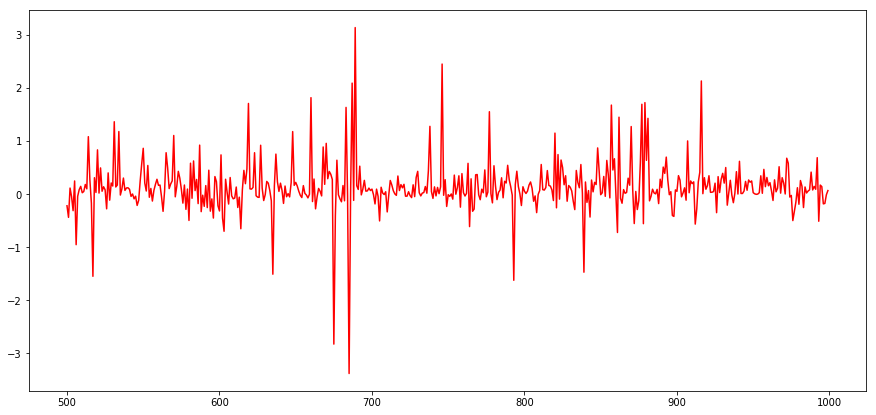

In [0]:
plt.figure(figsize=(15,7))
plt.plot(X_genfeatures['Skew'].iloc[500:1000], 'r')
# plt.plot(x, 'b')
plt.show()

In [0]:
x = scale('standard', np.array(X_genfeatures['Skew']).reshape(-1,1))

### Principal Component Analysis (PCA) on Train dataset

In [0]:
def pca (data):
  from sklearn.decomposition import PCA
  pca = PCA(n_components=5)
#   pca = PCA(.95)   # retain 95% of variance
  principalComponents_train = pca.fit_transform(data)
  pac_vars_train = [print (f'{pac_var*100:.2f}%\t', end="") for pac_var in pca.explained_variance_ratio_]
  print ()
  print (f'{np.sum(pca.explained_variance_ratio_)*100:.2f}%')
  return (principalComponents_train)

In [0]:
frames = [X_genfeatures, X_quantiles, X_rolling, X_mfcc1, X_mfcc2, X_fft1, X_fft2, X_fft3]
X_scaled = pd.concat(frames, axis=1)
X_scaled = scale('standard', X_scaled)

pc = pca(X_scaled)

# Deep Learning Models

In [0]:
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import r2_score, mean_absolute_error


##### For output consistency

In [0]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


###Model 1

In [0]:
def plot_hist(history):
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values=history_dict['val_loss']
  plt.xlabel('Epochs')
  plt.plot(loss_values, color='Blue', linestyle='dashed', marker='o', label='Training Loss')
  plt.plot(val_loss_values,color='Red', label='Validation Loss')
  plt.legend()
  plt.show()

def model1(X, y):
  name = 'Model 1'

  input_shape = X[0].shape

  model = Sequential()
  model.add(Dense(10, input_shape=input_shape, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1,activation='linear'))
  model.compile(Adam(lr=0.003), 
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

  # Runs model for 50 iterations and assigns this to 'history'
  history = model.fit(X, y, epochs = 25, batch_size=32, validation_split = 0.2, verbose=0)

  y_pred = model.predict(X)
  print(f'{name}: The R2 score on the Train set is:\t{r2_score(y, y_pred):.3f}')
  print(f'{name}: The Mean Absolute Error on the Train set is:\t{mean_absolute_error(y, y_pred):.3f}')
  
  # Plot Training & Validation Loss
  plot_hist(history)
  
  return(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Model 1: The R2 score on the Train set is:	0.433
Model 1: The Mean Absolute Error on the Train set is:	2.057


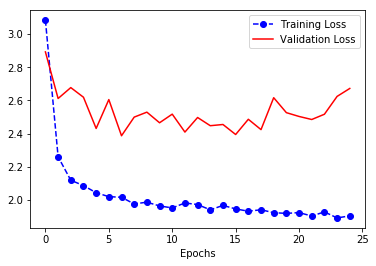

In [0]:
iters = 1

for iter in range(iters):
  model_1 = model1(X_scaled, y)
#   model_1 = model1(pc, y)

In [0]:
iters = 3
cols = X_scaled.shape[1]

for iter in range (iters):
  for col in range(cols,0,-1):
    X_scaled_sub = X_scaled[:,0:col]
    print (f'X_scaled_sub = {X_scaled_sub.shape}')
    model1(X_scaled_sub, y_series)

### Model 2

In [0]:
def plot_hist(history):
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values=history_dict['val_loss']
  plt.xlabel('Epochs')
  plt.plot(loss_values, color='Blue', linestyle='dashed', marker='o', label='Training Loss')
  plt.plot(val_loss_values,color='Red', label='Validation Loss')
  plt.legend()
  plt.show()

def model2(X, y):
  name = 'Model 2'

  input_shape = X[0].shape

  model = Sequential()
  model.add(Dense(512, input_shape=input_shape, activation='relu'))
#   model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam', 
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

  # Runs model for 50 iterations and assigns this to 'history'
  history = model.fit(X, y, epochs = 200, batch_size=32, validation_split = 0.2, verbose=0)

  y_pred = model.predict(X)
  print(f'{name}: The R2 score on the Train set is:\t{r2_score(y, y_pred):.3f}')
  print(f'{name}: The Mean Absolute Error on the Train set is:\t{mean_absolute_error(y, y_pred):.3f}')
  
  # Plot Training & Validation Loss
  plot_hist(history)
  
  return(model)

Model 2: The R2 score on the Train set is:	0.728
Model 2: The Mean Absolute Error on the Train set is:	1.113


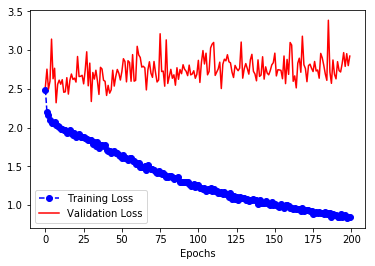

In [0]:
iters = 1

for iter in range(iters):
  model_2 = model2(X_scaled, y)
#   model_2 = model2(pc, y)

### Model 3

In [0]:
def plot_hist(history):
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values=history_dict['val_loss']
  plt.xlabel('Epochs')
  plt.plot(loss_values, color='Blue', linestyle='dashed', marker='o', label='Training Loss')
  plt.plot(val_loss_values,color='Red', label='Validation Loss')
  plt.legend()
  plt.show()

def model3(X, y):
  name = 'Model 3'

  input_shape = X[0].shape

  model = Sequential()
  model.add(Dense(256, input_shape=input_shape, activation='softmax'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam', 
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

  # Runs model and assigns it to 'history'
  history = model.fit(X, y, epochs = 200, batch_size=32, validation_split = 0.2, verbose=0)

  y_pred = model.predict(X)
  print(f'{name}: The R2 score on the Train set is:\t{r2_score(y, y_pred):.3f}')
  print(f'{name}: The Mean Absolute Error on the Train set is:\t{mean_absolute_error(y, y_pred):.3f}')
  
  # Plot Training & Validation Loss
  plot_hist(history)
  
  return(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Model 3: The R2 score on the Train set is:	0.783
Model 3: The Mean Absolute Error on the Train set is:	0.892


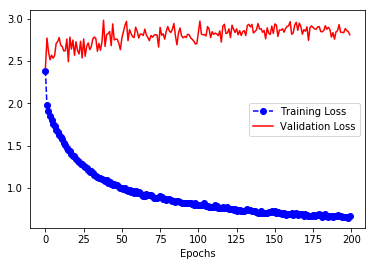

In [0]:
iters = 1
y = y_

for iter in range(iters):
  model_3 = model3(X_scaled, y)
#   model_3 = model3(pc, y)

In [0]:
y_pred1 = model_3.predict(X_test)
y_pred2 = model_3.predict(X_scaled)

print(f'The Mean Absolute Error on the Test set is: {mean_absolute_error(y_test, y_pred1):.5f}')
print(f'The R2 score on the Test set is:\t {r2_score(y_test, y_pred1):.5f}')
print(f'The Mean Absolute Error on the full set is: {mean_absolute_error(y, y_pred2):.5f}')
print(f'The R2 score on the full set is:\t {r2_score(y, y_pred2):.5f}')

The Mean Absolute Error on the Test set is: 2.43267
The R2 score on the Test set is:	 -0.12796
The Mean Absolute Error on the full set is: 1.17417
The R2 score on the full set is:	 0.69113


### Model 4 (LSTM)

In [0]:
def plot_hist(history):
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values=history_dict['val_loss']
  plt.xlabel('Epochs')
  plt.plot(loss_values, color='Blue', linestyle='dashed', marker='o', label='Training Loss')
  plt.plot(val_loss_values,color='Red', label='Validation Loss')
  plt.legend()
  plt.show()

def model4(X, y):
  name = 'Model 4 (LSTM)'

  input_shape = X[0].shape
#   input_shape = (None, 9)

  model = Sequential()
  model.reset_states()
  model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(32, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='rmsprop', 
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

  # Runs model and assigns it to 'history'
  history = model.fit(X, y, epochs = 35, batch_size=32, validation_split = 0.2, verbose=0)

  y_pred = model.predict(X)
  print(f'{name}: The R2 score on the Train set is:\t{r2_score(y, y_pred):.3f}')
  print(f'{name}: The Mean Absolute Error on the Train set is:\t{mean_absolute_error(y, y_pred):.3f}')
  
  # Plot Training & Validation Loss
  plot_hist(history)
  
  return(model)

In [0]:
iters = 1

for iter in range(iters):
  model_4 = model4(X_scaled_lstm, y)
#   model_4 = model4(pc, y)

In [0]:
# X_scaled_lstm=X_scaled.reshape(X_scaled.shape[0],1, X_scaled.shape[1])
# X_scaled_lstm = X_scaled
del (X_scaled_lstm)

In [0]:
X_scaled.shape, X_scaled_lstm.shape

((4194, 9), (4194, 1, 9))

### Model 5 (CNN)

In [0]:
import tensorflow.keras as keras
keras.backend.image_data_format(), X_train1_scaled.shape

('channels_last', (4195, 4))

In [0]:
X_train1_scaled_CNN = np.expand_dims(X_train1_scaled, axis=2) # reshape (4195, 5) to (4195, 5, 1)      

In [0]:
X_train1_scaled.shape, X_train1_scaled_CNN.shape

((4195, 4), (4195, 4, 1))

In [0]:
# input_shape = X_train1_scaled[0].shape
input_shape = (4,1)

name = 'CNN1'

model = Sequential()
model.add(Conv1D(64, 3, input_shape=input_shape, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='softmax'))

model.compile(Adam(), 
              loss='mean_absolute_error',
             metrics=['mean_absolute_error'])

# Runs model for 50 iterations and assigns this to 'history'
history = model.fit(X_train1_scaled_CNN, y_train1, epochs = 50, batch_size=32, validation_split = 0.2, verbose=0)

y_train1_pred = model.predict(X_train1_scaled_CNN)
print(f'{name}: The R2 score on the Train set is:\t{r2_score(y_train1, y_train1_pred):.3f}')
print(f'{name}: The Mean Absolute Error on the Train set is:\t{mean_absolute_error(y_train1, y_train1_pred):.3f}')

# Plot Training & Validation Loss
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.xlabel('Epochs')
plt.plot(loss_values, color='Blue', linestyle='dashed', marker='o', label='Training Loss')
plt.plot(val_loss_values,color='Red', label='Validation Loss')
plt.legend()
plt.show()

# Other Regression Models

### Hyperparameter tuning using RandomizedSearchCV

In [0]:
# Hyperparameter tuning via RandomizedSearchCV

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor


def rsearchcv(model, regressor, X, y):
  if (model == 'RandomForrest'):
    max_depth_vals = list(range(2,10))
    n_estimators_vals = list(range(30,50,2))
    min_samples_split_vals = list(range(2,10))
    min_samples_leaf_vals = list(range(2,10))
    param_dist = dict(max_depth=max_depth_vals, n_estimators=n_estimators_vals, min_samples_split=min_samples_split_vals, \
                     min_samples_leaf=min_samples_leaf_vals)
  elif (model == 'LightGBM'):
    num_leaves_vals = list(range(2,10))
    min_data_in_leaf_vals = list(range(5,15))
    max_bin_vals = list(range(50,150,10))
    colsample_bytree_vals = np.arange(0.1,1,0.1)
    learning_rate_vals=np.arange(0.01,0.11,0.01)
    n_estimators_vals=np.arange(10,31)
    boosting_type_vals = ['goss', 'gbdt', 'dart']
    param_dist = dict(num_leaves=num_leaves_vals, min_data_in_leaf=min_data_in_leaf_vals, max_bin=max_bin_vals, \
                     colsample_bytree=colsample_bytree_vals, learning_rate=learning_rate_vals, n_estimators=n_estimators_vals, boosting_type=boosting_type_vals)
  
  rand = RandomizedSearchCV(regressor, param_dist, cv=10, scoring='neg_mean_absolute_error', n_iter=10, random_state=6, return_train_score=False)
  rand.fit(X, y)
  rand_df = pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
  print (f'best score = {rand.best_score_}, best params = {rand.best_params_}')

#main  
model = 'RandomForrest'
regressor = RandomForestRegressor(max_features='auto', warm_start=True, verbose=0, random_state=6)
model = 'LightGBM'
regressor = lgb.LGBMRegressor(objective='regression_l1', metric='mae', verbose=0, random_state=6)

(X_train, X_test, y_train, y_test) = kfold(X_scaled, y)
rsearchcv(model, regressor, X_scaled, y)
rsearchcv(model, regressor, X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best score = -2.26935870390064, best params = {'num_leaves': 9, 'n_estimators': 30, 'min_data_in_leaf': 14, 'max_bin': 50, 'learning_rate': 0.05, 'colsample_bytree': 0.9, 'boosting_type': 'gbdt'}
best score = -2.3494345466441082, best params = {'num_leaves': 9, 'n_estimators': 30, 'min_data_in_leaf': 14, 'max_bin': 50, 'learning_rate': 0.05, 'colsample_bytree': 0.9, 'boosting_type': 'gbdt'}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Model Testing

In [0]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool

#########################################################################################################
# Use k-fold to create Train & Test sets
######################################################################################################### 
def kfold (X, y):
  kfold = KFold(n_splits=10, random_state=6)
  for fold_n, (train_index, test_index) in enumerate(kfold.split(X)):  
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
  return (X_train, X_test, y_train, y_test)
#########################################################################################################
def model_score(set_type, y, y_pred):
  print(f'The Mean Absolute Error of the {set_type} set is: {mean_absolute_error(y, y_pred):.5f}')
#   print(f'The R2 score of the {set_type} set is:\t {r2_score(y, y_pred):.5f}')
#########################################################################################################
# Functions to Train model & make Predictions
train_model = lambda regressor, X, y: regressor.fit(X, y)
make_prediction = lambda regressor, X:  pd.Series(regressor.predict(X))
#########################################################################################################
def get_regressor(model):
  if (model == 'RandomForrest'):
    rf_params = {'max_depth' : 2, 'random_state' : 6, 'n_estimators' : 15, 'max_features': 50,'verbose' : 0}
    rf_params = {'verbose' : 0, 'max_depth' : 50, 'max_features': 10}
    return (RandomForestRegressor(**rf_params))
  elif (model == 'XGBoost'):
    xgb_params = {'n_estimators': 100, 'eta' : 0.3, 'gamma' : 0, 'subsample' : 0.6,'colsample_bytree' : 0.6,\
                'max_depth' : 6, 'seed' : 30, 'random_state': 6, 'seed': 6,'eta': 0.03, 'objective': 'reg:linear',\
                  'eval_metric': 'mae','silent': 0}
    xgb_params = {
                  'objective': 'reg:linear'
                  }
    return (XGBRegressor(**xgb_params))
  elif (model == 'CatBoost'):
    cat_params = {'iterations' : 70, 'random_strength' : 14, 'depth' : 4, 
                  'verbose' : False
                 }
    cat_params = {'iterations' : 100, 'depth' : 5, 'eval_metric' : 'MAE', 'learning_rate' : 0.9,
                  'l2_leaf_reg' : 15, 
                  'verbose' : False
                 }
    cat_params = {
                  'verbose' : False, 'task_type': 'GPU',  'iterations' : 999, 'learning_rate' : 0.09, 'eval_metric' : 'MAE'
                 }
    cat_params = {
                  'verbose' : False, 'task_type' : 'GPU', 'eval_metric' : 'MAE'
                 }
    return (CatBoostRegressor(**cat_params))
  elif (model == 'LightGBM'):
    lgb_params = {
                 'boosting_type' : 'gbdt', 'learning_rate' : 0.03, 'max_depth' : 2, 'n_estimators' : 91,
                  'objective' : 'regression_l1', 'max_bin' : 100, 'n_jobs' : 2, 'num_iterations' : 120,
                  'subsample' : 0.9, 'subsample_freq' : 8
                 }
    lgb_params = {
                  'boosting_type' : 'gbdt', 'learning_rate' : 0.09,
                  'objective' : 'regression_l1', 'num_iterations' : 200, 'num_leaves' : 40, 
                  'feature_fraction': 0.5, 'metric': 'mae', 'reg_sqrt' : True,
                  }
    lgb_params = {
                  'boosting_type' : 'dart', 'objective' : 'regression_l1', 'metric' : 'mae',
                  'learning_rate' : 0.11,  'num_iterations' : 120, 'num_leaves' : 100,
                  }
    lgb_params = {
                  'boosting_type' : 'dart', 'objective' : 'regression_l1', 'metric' : 'mae',
                  }
    return (lgb.LGBMRegressor(**lgb_params))

#########################################################################################################
(X_train, X_test, y_train, y_test) = kfold(X_scaled, y)

models = ['LightGBM', 'CatBoost']
# models = ['RandomForrest']
# models = ['LightGBM']
# models = ['XGBoost']
# models = ['CatBoost']

eval_dataset = Pool(X_test, y_test)

preds_XyTrain_test = pd.DataFrame()
preds_XyTrain_full = pd.DataFrame()
preds_Xy_test = pd.DataFrame()
preds_Xy_full = pd.DataFrame()

for model in models:
  regressor = get_regressor(model)
  print (f'{model}')
  regressor = train_model(regressor, X_train, y_train)
  y_pred = make_prediction(regressor, X_test)
  preds_XyTrain_test[f'{model}_test'] = y_pred
  model_score('XyTrain Test', y_test, y_pred)
  y_pred = make_prediction(regressor, X_scaled)
  preds_XyTrain_full[f'{model}_full'] = y_pred
  model_score('XyTrain Full', y, y_pred)
  print ()
  regressor = train_model(regressor, X_scaled, y)
  y_pred = make_prediction(regressor, X_test)
  preds_Xy_test[f'{model}_test'] = y_pred
  model_score('Xy Test', y_test, y_pred)
  y_pred = make_prediction(regressor, X_scaled)
  preds_Xy_full[f'{model}_full'] = y_pred
  model_score('Xy Full', y, y_pred)
  
  print ('------------------------------------------------------------------------------------')

cols = preds_XyTrain_test.loc[:, [f'{i}_test' for i in models]]
preds_XyTrain_test['Average_test'] = cols.mean(axis=1)
model_score('Average XyTrain Test', y_test, preds_XyTrain_test["Average_test"].values)
cols = preds_XyTrain_full.loc[:, [f'{i}_full' for i in models]]
preds_XyTrain_full['Average_full'] = cols.mean(axis=1)
model_score('Average Xytrain Full', y, preds_XyTrain_full["Average_full"].values)
print ()
cols = preds_Xy_test.loc[:, [f'{i}_test' for i in models]]
preds_Xy_test['Average_test'] = cols.mean(axis=1)
model_score('Average Xy Test', y_test, preds_Xy_test["Average_test"].values)
cols = preds_Xy_full.loc[:, [f'{i}_full' for i in models]]
preds_Xy_full['Average_full'] = cols.mean(axis=1)
model_score('Average Xy Full', y, preds_Xy_full["Average_full"].values)

LightGBM
The Mean Absolute Error of the XyTrain Test set is: 1.68089
The Mean Absolute Error of the XyTrain Full set is: 1.74676

The Mean Absolute Error of the Xy Test set is: 1.01314
The Mean Absolute Error of the Xy Full set is: 1.74131
------------------------------------------------------------------------------------
CatBoost
The Mean Absolute Error of the XyTrain Test set is: 2.22012
The Mean Absolute Error of the XyTrain Full set is: 1.79451

The Mean Absolute Error of the Xy Test set is: 1.24122
The Mean Absolute Error of the Xy Full set is: 1.68340
------------------------------------------------------------------------------------
The Mean Absolute Error of the Average XyTrain Test set is: 1.91427
The Mean Absolute Error of the Average Xytrain Full set is: 1.73199

The Mean Absolute Error of the Average Xy Test set is: 1.02538
The Mean Absolute Error of the Average Xy Full set is: 1.66921


### Select train, test data set

In [0]:
# X5 = df_relevant[['IQR', 'std_1%_win20', 'mfcc_skew_2', 'mfcc_skew_3']]

# frames = [X_genfeatures, X_quantiles, X_rolling, X_mfcc1, X_mfcc2, X_mfcc3, X_misc_aud, X_fft1, X_fft2, X_fft3, X_fft4, X_fft5]
# frames = [X_genfeatures_, X_quantiles_, X_rolling_, X_mfcc1_, X_mfcc2_, X_mfcc3_, X_fft1_, X_fft2_, X_fft3_, X_fft4_, X_fft5_]
# frames = [X_mfcc1, X_fft3, X_fft4, X_fft5]
# frames = [X_mfcc1, X_fft3]
# frames = [X_mfcc1, X_mfcc2, X_mfcc3]
# frames = [X_mfcc1_, X_fft3_, X_fft4_, X_fft5_]
# frames = [X_mfcc1, X_mfcc2, X_fft3]
# frames = [X_misc_aud_, X_fft3_]
# frames = [df_relevant]
# frames = [df_relevant]
# frames = [X_genfeatures, X_quantiles, X_rolling]
# frames = [X_mfcc1, X_mfcc2, X_mfcc3, X_misc_aud]
frames = [X_fft1, X_fft2, X_fft3, X_fft4, X_fft5]
X_scaled = pd.concat(frames, axis=1)
X_scaled = scale('standard', X_scaled)

# y = y_
y = y_basic

In [0]:
frames = [X_genfeatures, X_quantiles, X_rolling, X_mfcc1, X_mfcc2, X_mfcc3, X_misc_aud, X_fft1, X_fft2, X_fft3, X_fft4, X_fft5]
X_scaled = pd.concat(frames, axis=1)
X_scaled = X_scaled[cols_lgbm_cat]
X_scaled = scale('standard', X_scaled)

y = y_basic

In [0]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error


params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
cols_lgbm = []
cols_cat = []

plt.figure(figsize=(20,50))

lgb_params = {
             'boosting_type' : 'dart', 'objective' : 'regression_l1', 'metric' : 'mae',
             }
clf = lgb.LGBMRegressor(**lgb_params)
clf.fit(X_train, y_train)
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance_lgbm = 100.0 * (feature_importance / feature_importance.max())
sorted_idx_lgbm = np.argsort(feature_importance_lgbm)
pos = np.arange(sorted_idx_lgbm.shape[0]) + .5
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_lgbm[sorted_idx_lgbm], align='center')
plt.yticks(pos, pd.concat(frames, axis=1).columns.values[sorted_idx_lgbm])
plt.xlabel('Relative Importance')
plt.title('LGBM Variable Importance')

for i in sorted_idx_lgbm[-1::-1]:
  if (feature_importance_lgbm[i] >= 30):
    cols_lgbm.append(pd.concat(frames, axis=1).columns.values[i])

cat_params = {
                  'verbose' : False, 'task_type' : 'GPU', 'eval_metric' : 'MAE'
                 }
clf = CatBoostRegressor(**cat_params)
clf.fit(X_train, y_train)
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance_cat = 100.0 * (feature_importance / feature_importance.max())
sorted_idx_cat = np.argsort(feature_importance_cat)
pos = np.arange(sorted_idx_cat.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance_cat[sorted_idx_cat], align='center')
plt.yticks(pos, pd.concat(frames, axis=1).columns.values[sorted_idx_cat])
plt.xlabel('Relative Importance')
plt.title('Catboost Variable Importance')

for i in sorted_idx_cat[-1::-1]:
  if (feature_importance_cat[i] >= 30):
    cols_cat.append(pd.concat(frames, axis=1).columns.values[i]) 
    
cols_lgbm_cat = cols_lgbm + cols_cat
cols_lgbm_cat = sorted(list(set(cols_lgbm_cat)))
cols_lgbm_cat_common = list(set(cols_lgbm).intersection(cols_cat))



plt.show()

In [0]:
# cols1 = cols_lgbm_cat
# cols1_common = cols_lgbm_cat_common
# cols2 = cols_lgbm_cat
# cols2_common = cols_lgbm_cat_common
# cols3 = cols_lgbm_cat
# cols3_common = cols_lgbm_cat_common

In [0]:
cols_lgbm_cat = cols1 + cols2 + cols3
cols_lgbm_cat = sorted(list(set(cols_lgbm_cat)))


cols_lgbm_cat_common = cols1_common + cols2_common + cols3_common
cols_lgbm_cat_common = sorted(list(set(cols_lgbm_cat_common)))

In [0]:
frames = {'X_genfeatures':X_genfeatures, 'X_quantiles':X_quantiles, 'X_rolling':X_rolling, 
          'X_mfcc1':X_mfcc1, 'X_mfcc2':X_mfcc2, 'X_mfcc3':X_mfcc3,
          'X_fft1':X_fft1, 'X_fft2':X_fft2, 'X_fft3':X_fft3, 'X_fft4':X_fft4, 'X_fft5':X_fft5, 'X_misc_aud':X_misc_aud, 'X_misc_aud_':X_misc_aud_}
frames = {'X_mfcc1':X_mfcc1, 'X_mfcc2':X_mfcc2, 'X_mfcc3':X_mfcc3, 'X_misc_aud':X_misc_aud}
y = y_basic

# frames = {'X_genfeatures_':X_genfeatures_, 'X_quantiles_':X_quantiles_, 'X_rolling_':X_rolling_,
#           'X_mfcc1_':X_mfcc1_, 'X_mfcc2_':X_mfcc2_, 'X_mfcc3_':X_mfcc3_,
#           'X_fft1_':X_fft1_, 'X_fft2_':X_fft2_, 'X_fft3_':X_fft3_, 'X_fft4_':X_fft4_, 'X_fft5_':X_fft5_}
# y = y_


for frame in frames:
  X_scaled = pd.concat([frames[frame]], axis=1)
  X_scaled = scale('standard', X_scaled)
  
  print (frame)
#   models = ['LightGBM']
#   models = ['RandomForrest']
  models = ['CatBoost']
  for model in models:
    regressor = get_regressor(model)
    (X_train, X_test, y_train, y_test) = kfold(X_scaled, y)
    regressor = train_model(regressor, X_train, y_train)
    y_pred = make_prediction(regressor, X_test)
    preds_XyTrain_test[f'{model}_test'] = y_pred
    model_score('XyTrain Test', y_test, y_pred)
    y_pred = make_prediction(regressor, X_scaled)
    preds_XyTrain_full[f'{model}_full'] = y_pred
    model_score('XyTrain Full', y, y_pred)

X_mfcc1
The Mean Absolute Error of the XyTrain Test set is: 1.66083
The Mean Absolute Error of the XyTrain Full set is: 1.76241
X_mfcc2
The Mean Absolute Error of the XyTrain Test set is: 1.83284
The Mean Absolute Error of the XyTrain Full set is: 1.61391
X_mfcc3
The Mean Absolute Error of the XyTrain Test set is: 1.98630
The Mean Absolute Error of the XyTrain Full set is: 1.78466
X_misc_aud
The Mean Absolute Error of the XyTrain Test set is: 2.10263
The Mean Absolute Error of the XyTrain Full set is: 1.73551


### Visualize Model Performance

In [0]:
preds_Xy_full.head()

,LightGBM_full,Average_full
0,3.647835,3.647835
1,3.587513,3.587513
2,2.017185,2.017185
3,3.704111,3.704111
4,3.444519,3.444519


In [0]:
DATADIR = '/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/submissions'
file = 'submission_28.csv'


df_28 = pd.read_csv(f'{DATADIR}/{file}')

In [0]:
plt.figure(figsize=(20,20))

ax0 = plt.subplot2grid((5,1), (0,0), rowspan=1, colspan=1)
ax0.plot(preds_XyTrain_test['Average_test'], 'b')
# ax0.plot(preds_XyTrain_test['Average_test'], 'b')
ax0.plot(y_test.values, 'go--')
ax0.set_xlabel('Samples')
ax0.set_ylabel('preds_XyTrain_test')
ax0.set_title('preds_XyTrain_test')
ax0.legend()

ax1 = plt.subplot2grid((5,1), (1,0), rowspan=1, colspan=1)
# ax1.plot(preds_XyTrain_test['LightGBM_test'], 'b')
# ax1.plot(preds_XyTrain_test['CatBoost_test'], 'r')
ax1.plot(preds_XyTrain_test['Average_test'], 'c')
ax1.plot(y_test.values, 'go--')
ax1.set_xlabel('Samples')
ax1.set_ylabel('preds_XyTrain_test')
ax1.set_title('preds_XyTrain_test')
ax1.legend()

ax2 = plt.subplot2grid((5,1), (2,0), rowspan=1, colspan=1)
# ax2.plot(preds_Xy_test['LightGBM_test'], 'b')
# ax2.plot(preds_Xy_test['CatBoost_test'], 'r')
ax2.plot(preds_Xy_test['Average_test'], 'c')
ax2.plot(y_test.values, 'go--')
ax2.set_xlabel('Samples')
ax2.set_ylabel('preds_Xy_test')
ax2.set_title('preds_Xy_test')
ax2.legend()

ax3 = plt.subplot2grid((5,1), (3,0), rowspan=1, colspan=1)
# ax3.plot(preds_XyTrain_full['LightGBM_full'], 'b')
# ax3.plot(preds_XyTrain_full['CatBoost_full'], 'r')
ax3.plot(preds_XyTrain_full['Average_full'], 'c')
ax3.plot(y.values, 'go--')
ax3.set_xlabel('Samples')
ax3.set_ylabel('preds_XyTrain_full')
ax3.set_title('preds_XyTrain_full')
ax3.legend()

ax4 = plt.subplot2grid((5,1), (4,0), rowspan=1, colspan=1)
# ax4.plot(preds_Xy_full['LightGBM_full'], 'b')
# ax4.plot(preds_Xy_full['CatBoost_full'], 'r')
ax4.plot(preds_Xy_full['Average_full'], 'c')
ax4.plot(y.values, ls='--', marker='o', color='g')
ax4.set_xlabel('Samples')
ax4.set_ylabel('preds_Xy_full')
ax4.set_title('preds_Xy_full')
ax4.legend()

plt.show()


In [0]:
fig, ax1 = plt.subplots(figsize=(15,7))
plt.plot(ad, color-='b')
ax1.set_ylabel('Acoustic Data', color='b')
plt.legend(['Acoustic Data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(ttf, color='r')
ax2.set_ylabel('Time To Failure', color='r')
plt.legend(['Time To Failure'], loc=(0.01, 0.9))


# Test dataset

### Load Test  & generate Engineered features Test datasets

In [0]:
!ls '/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test'

In [0]:
import os
import pandas as pd

DATADIR = '/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test'
X_test_genfeatures = pd.DataFrame()
X_test_quantiles = pd.DataFrame()
X_test_rolling = pd.DataFrame()
X_test_mfcc1 = pd.DataFrame()
X_test_mfcc2 = pd.DataFrame()
X_test_mfcc3 = pd.DataFrame()
X_test_misc_aud = pd.DataFrame()
X_test_fft1 = pd.DataFrame()
X_test_fft2 = pd.DataFrame()
X_test_fft3 = pd.DataFrame()
X_test_fft4 = pd.DataFrame()
X_test_fft5 = pd.DataFrame()

i = 1

for file in os.listdir(DATADIR):
  df_tmp = pd.read_csv(os.path.join(DATADIR, file))
  df_tmp = df_tmp.transpose().loc['acoustic_data']
  
#   ch = gen_features(df_tmp)
#   X_test_genfeatures = X_test_genfeatures.append(ch, ignore_index=True)
#   ch = quantiles(df_tmp)
#   X_test_quantiles = X_test_quantiles.append(ch, ignore_index=True)
#   ch = rolling(df_tmp)
#   X_test_rolling = X_test_rolling.append(ch, ignore_index=True)
#   ch = mfcc1(df_tmp)
#   X_test_mfcc1 = X_test_mfcc1.append(ch, ignore_index=True)
#   ch = mfcc2(df_tmp)
#   X_test_mfcc2 = X_test_mfcc2.append(ch, ignore_index=True)
#   ch = mfcc3(df_tmp)
#   X_test_mfcc3 = X_test_mfcc3.append(ch, ignore_index=True)
  ch = misc_aud(df_tmp)
  X_test_misc_aud = X_test_misc_aud.append(ch, ignore_index=True)

#   ch = fft1(df_tmp)
#   X_test_fft1 = X_test_fft1.append(ch, ignore_index=True)
#   ch = fft2(df_tmp)
#   X_test_fft2 = X_test_fft2.append(ch, ignore_index=True)
#   ch = fft3(df_tmp)
#   X_test_fft3 = X_test_fft3.append(ch, ignore_index=True)
#   ch = fft4(df_tmp)
#   X_test_fft4 = X_test_fft4.append(ch, ignore_index=True)
#   ch = fft5(df_tmp)
#   X_test_fft5 = X_test_fft5.append(ch, ignore_index=True)
#   ch['seg_id'] = file.split('.')[0]
  
  
  print (f'{i}: {file}')
  i += 1

  
# X_test_genfeatures.columns = [
#              'Mean', 'Std', 'Min', 'Max', 'Kurtosis', 'Skew', 'Abs Max', 'Abs Mean', 'Abs Std','Nan Var', 'Var', 'Peak2Peak', 'IQR', 'Ave10', 'Trend', 'Abs Trend' 
#             ]

# X_test_quantiles.columns = [
#              'Quantile 0.1%', 'Quantile 1%', 'Quantile 5%', 'Quantile 95%', 'Quantile 99%', 'Quantile 99.9%' 
#             ]

# X_test_rolling.columns = [
#              'std_1%_win20', 'std_5%_win20', 'std_95%_win20', 'std_99%_win20', 'mean_1%_win20', 'mean_5%_win20', 'mean_95%_win20', 'mean_99%_win20',\
#             'std_1%_win50', 'std_5%_win50', 'std_95%_win50', 'std_99%_win50', 'mean_1%_win50', 'mean_5%_win50', 'mean_95%_win50', 'mean_99%_win50',\
#             'std_1%_win100', 'std_5%_win100', 'std_95%_win100', 'std_99%_win100', 'mean_1%_win100', 'mean_5%_win100', 'mean_95%_win100', 'mean_99%_win100',\
#             'std_1%_win150', 'std_5%_win150', 'std_95%_win150', 'std_99%_win150', 'mean_1%_win150', 'mean_5%_win150', 'mean_95%_win150', 'mean_99%_win150',\
#             'std_1%_win200', 'std_5%_win200', 'std_95%_win200', 'std_99%_win200', 'mean_1%_win200', 'mean_5%_win200', 'mean_95%_win200', 'mean_99%_win200',\
#             'std_1%_win250', 'std_5%_win250', 'std_95%_win250', 'std_99%_win250', 'mean_1%_win250', 'mean_5%_win250', 'mean_95%_win250', 'mean_99%_win250',\
#             'std_1%_win300', 'std_5%_win300', 'std_95%_win300', 'std_99%_win300', 'mean_1%_win300', 'mean_5%_win300', 'mean_95%_win300', 'mean_99%_win300',\
#             'std_1%_win400', 'std_5%_win400', 'std_95%_win400', 'std_99%_win400', 'mean_1%_win400', 'mean_5%_win400', 'mean_95%_win400', 'mean_99%_win400',\
#             'std_1%_win500', 'std_5%_win500', 'std_95%_win500', 'std_99%_win500', 'mean_1%_win500', 'mean_5%_win500', 'mean_95%_win500', 'mean_99%_win500',\
#             'std_1%_win1000', 'std_5%_win1000', 'std_95%_win1000', 'std_99%_win1000', 'mean_1%_win1000', 'mean_5%_win1000', 'mean_95%_win1000', 'mean_99%_win1000',
#             'std_1%_win1500', 'std_5%_win1500', 'std_95%_win1500', 'std_99%_win1500', 'mean_1%_win1500', 'mean_5%_win1500', 'mean_95%_win1500', 'mean_99%_win1500',\
#             'std_1%_win2000', 'std_5%_win2000', 'std_95%_win2000', 'std_99%_win2000', 'mean_1%_win2000', 'mean_5%_win2000', 'mean_95%_win2000', 'mean_99%_win2000',\
#             'std_1%_win2500', 'std_5%_win2500', 'std_95%_win2500', 'std_99%_win2500', 'mean_1%_win2500', 'mean_5%_win2500', 'mean_95%_win2500', 'mean_99%_win2500',\
#             'std_1%_win3000', 'std_5%_win3000', 'std_95%_win3000', 'std_99%_win3000', 'mean_1%_win3000', 'mean_5%_win3000', 'mean_95%_win3000', 'mean_99%_win3000',\
#             'std_1%_win3500', 'std_5%_win3500', 'std_95%_win3500', 'std_99%_win3500', 'mean_1%_win3500', 'mean_5%_win3500', 'mean_95%_win3500', 'mean_99%_win3500',\
#             'std_1%_win4000', 'std_5%_win4000', 'std_95%_win4000', 'std_99%_win4000', 'mean_1%_win4000', 'mean_5%_win4000', 'mean_95%_win4000', 'mean_99%_win4000',\
#             'std_1%_win4500', 'std_5%_win4500', 'std_95%_win4500', 'std_99%_win4500', 'mean_1%_win4500', 'mean_5%_win4500', 'mean_95%_win4500', 'mean_99%_win4500',\
#             'std_1%_win5000', 'std_5%_win5000', 'std_95%_win5000', 'std_99%_win5000', 'mean_1%_win5000', 'mean_5%_win5000', 'mean_95%_win5000', 'mean_99%_win5000',\
#             'seg_id'
#             ]

# X_test_mfcc1.columns = [
#              'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
#              'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19' 
#             ]

# X_test_mfcc2.columns = [
#              'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 
#              'mfcc_mean_10','mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 'mfcc_mean_18', 
#              'mfcc_mean_19',
#              'mfcc_std_0', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9',
# 			       'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13', 'mfcc_std_14', 'mfcc_std_15', 'mfcc_std_16', 'mfcc_std_17', 'mfcc_std_18',
# 			       'mfcc_std_19',
#              'mfcc_skew_0', 'mfcc_skew_1', 'mfcc_skew_2', 'mfcc_skew_3', 'mfcc_skew_4', 'mfcc_skew_5', 'mfcc_skew_6', 'mfcc_skew_7', 'mfcc_skew_8', 'mfcc_skew_9',
# 			       'mfcc_skew_10', 'mfcc_skew_11', 'mfcc_skew_12', 'mfcc_skew_13', 'mfcc_skew_14', 'mfcc_skew_15', 'mfcc_skew_16', 'mfcc_skew_17', 'mfcc_skew_18',
# 			       'mfcc_skew_19',
#              'rms_mean', 'rms_std', 'rms_skew', 'speccent_mean', 'speccent_std', 'speccent_skew'
#             ]

# X_test_mfcc3.columns = [
#              'mfcc_sr4MHz_0', 'mfcc_sr4MHz_1', 'mfcc_sr4MHz_2', 'mfcc_sr4MHz_3', 'mfcc_sr4MHz_4', 'mfcc_sr4MHz_5', 'mfcc_sr4MHz_6', 'mfcc_sr4MHz_7',
#              'mfcc_sr4MHz_8', 'mfcc_sr4MHz_9', 'mfcc_sr4MHz_10', 'mfcc_sr4MHz_11', 'mfcc_sr4MHz_12', 'mfcc_sr4MHz_13', 'mfcc_sr4MHz_14', 'mfcc_sr4MHz_15',
#              'mfcc_sr4MHz_16', 'mfcc_sr4MHz_17', 'mfcc_sr4MHz_18', 'mfcc_sr4MHz_19' 
#             ]

X_test_misc_aud.columns = [
             'chroma_stft', 'chroma_stft_sr4MHz','rmse', 'spec_cent', 'spec_cent_sr4MHz', 'spec_bw', 'spec_bw_sr4MHz', 'rolloff', 'rolloff_sr4MHz', 'zcr',
             'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
             'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19',
             'mfcc_sr4MHz_0', 'mfcc_sr4MHz_1', 'mfcc_sr4MHz_2', 'mfcc_sr4MHz_3', 'mfcc_sr4MHz_4', 'mfcc_sr4MHz_5', 'mfcc_sr4MHz_6', 'mfcc_sr4MHz_7',
             'mfcc_sr4MHz_8', 'mfcc_sr4MHz_9', 'mfcc_sr4MHz_10', 'mfcc_sr4MHz_11', 'mfcc_sr4MHz_12', 'mfcc_sr4MHz_13', 'mfcc_sr4MHz_14', 'mfcc_sr4MHz_15',
             'mfcc_sr4MHz_16', 'mfcc_sr4MHz_17', 'mfcc_sr4MHz_18', 'mfcc_sr4MHz_19'
            ]

# X_test_fft1.columns = [
#              'fft_abs_mean', 'fft_abs_std', 'fft_abs_min', 'fft_abs_max', 'fft_abs_kurtosis', 'fft_abs_skew',
#              'fft_abs_1%', 'fft_abs_5%', 'fft_abs_95%', 'fft_abs_99%'
#             ]

# X_test_fft2.columns = [
#              'fft_r_1%', 'fft_r_5%', 'fft_r_95%', 'fft_r_99%', 'fft_i_1%', 'fft_i_5%', 'fft_i_95%', 'fft_i_99%'
#             ]

# X_test_fft3.columns = [
#              'fft_top_mean', 'fft_top_std', 'fft_top_min', 'fft_top_max', 'fft_top_kurtosis', 'fft_top_skew',
#              'fft_top_1%', 'fft_top_5%', 'fft_top_95%', 'fft_top_99%',
#              'fft_bottom_mean', 'fft_bottom_std', 'fft_bottom_min', 'fft_bottom_max', 'fft_bottom_kurtosis', 'fft_bottom_skew',
#              'fft_bottom_1%', 'fft_bottom_5%', 'fft_bottom_95%', 'fft_bottom_99%'
#             ]

# X_test_fft4.columns = [
#              'fft_r_top_mean', 'fft_r_top_std', 'fft_r_top_min', 'fft_r_top_max', 'fft_r_top_kurtosis', 'fft_r_top_skew',
#              'fft_r_top_1%', 'fft_r_top_5%', 'fft_r_top_95%', 'fft_r_top_99%',
#              'fft_r_bottom_mean', 'fft_r_bottom_std', 'fft_r_bottom_min', 'fft_r_bottom_max', 'fft_r_bottom_kurtosis', 'fft_r_bottom_skew',
#              'fft_r_bottom_1%', 'fft_r_bottom_5%', 'fft_r_bottom_95%', 'fft_r_bottom_99%',
#              'fft_i_top_mean', 'fft_i_top_std', 'fft_i_top_min', 'fft_i_top_max', 'fft_i_top_kurtosis', 'fft_i_top_skew',
#              'fft_i_top_1%', 'fft_i_top_5%', 'fft_i_top_95%', 'fft_i_top_99%',
#              'fft_i_bottom_mean', 'fft_i_bottom_std', 'fft_i_bottom_min', 'fft_i_bottom_max', 'fft_i_bottom_kurtosis', 'fft_i_bottom_skew',
#              'fft_i_bottom_1%', 'fft_i_bottom_5%', 'fft_i_bottom_95%', 'fft_i_bottom_99%'
#             ]

# X_test_fft5.columns = [
#              'fft_abs_filter1_mean', 'fft_abs_filter1_std', 'fft_abs_filter1_min', 'fft_abs_filter1_max', 'fft_abs_filter1_kurtosis', 'fft_abs_filter1_skew',
#              'fft_abs_filter1_1%', 'fft_abs_filter1_5%', 'fft_abs_filter1_95%', 'fft_abs_filter1_99%'
#             ]

In [0]:
frames = [X_test_genfeatures, X_test_quantiles, X_test_rolling, X_test_mfcc]
X_test_genfeatures_quantiles_rolling_mfcc = pd.concat(frames, axis=1)

### Pickle Test Features

In [0]:
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_genfeatures.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_genfeatures, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_quantiles.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_quantiles, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_rolling.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_rolling, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_mfcc1.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_mfcc1, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_mfcc2.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_mfcc2, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_mfcc3.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_mfcc3, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_misc_aud.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_misc_aud, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft1.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_fft1, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft2.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_fft2, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft3.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_fft3, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft4.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_fft4, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft5.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_fft5, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_genfeatures_quantiles_rolling.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_genfeatures_quantiles_rolling, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_genfeatures_quantiles_rolling_mfcc.pkl', 'wb') as pklfile:
#   pickle.dump(X_test_genfeatures_quantiles_rolling_mfcc, pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/seg_id.pkl', 'wb') as pklfile:
#   pickle.dump(seg_id, pklfile)

 
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_genfeatures.pkl', 'rb') as pklfile:
  X_test_genfeatures = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_quantiles.pkl', 'rb') as pklfile:
  X_test_quantiles = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_rolling.pkl', 'rb') as pklfile:
  X_test_rolling = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_mfcc1.pkl', 'rb') as pklfile:
  X_test_mfcc1 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_mfcc2.pkl', 'rb') as pklfile:
  X_test_mfcc2 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_mfcc3.pkl', 'rb') as pklfile:
  X_test_mfcc3 = pickle.load(pklfile) 
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_misc_aud.pkl', 'rb') as pklfile:
  X_test_misc_aud = pickle.load(pklfile) 
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft1.pkl', 'rb') as pklfile:
  X_test_fft1 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft2.pkl', 'rb') as pklfile:
  X_test_fft2 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft3.pkl', 'rb') as pklfile:
  X_test_fft3 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft4.pkl', 'rb') as pklfile:
  X_test_fft4 = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_fft5.pkl', 'rb') as pklfile:
  X_test_fft5 = pickle.load(pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_genfeatures_quantiles_rolling.pkl', 'rb') as pklfile:
#   X_test_genfeatures_quantiles_rolling = pickle.load(pklfile)
# with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/X_test_genfeatures_quantiles_rolling_mfcc.pkl', 'rb') as pklfile:
#   X_test_genfeatures_quantiles_rolling_mfcc = pickle.load(pklfile)
with open ('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/test_features/seg_id.pkl', 'rb') as pklfile:
  seg_id = pickle.load(pklfile)

In [0]:
frames = [X_genfeatures, X_quantiles, X_rolling, X_mfcc1, X_mfcc2, X_mfcc3, X_fft1, X_fft2, X_fft3, X_fft4, X_fft5]

X_fft5.shape, X_test_fft5.shape

((4195, 10), (2624, 10))

### Principal Component Analysis (PCA) on Engineered features Test dataset

In [0]:
from sklearn.decomposition import PCA
pca = PCA(.95)   # retain 95% of variance
principalComponents_test = pca.fit_transform(X_test_genfeatures_quantiles_rolling_scaled.drop(columns=['seg_id']))
pac_vars_test = [print (f'{pac_var*100:.2f}%\t', end="") for pac_var in pca.explained_variance_ratio_]

54.16%	24.10%	14.05%	1.64%	1.20%	

### Predictions on test data

#### DL Models

In [0]:
# Model_1
pred_df_1 = pd.DataFrame()
pred = model_1.predict(X_eng_test_scaled.iloc[:,:-1])
pred_df_1['seg_id'] = pd.Series(X_eng_test_scaled['filename'].values)
pred_df_1['time_to_failure'] = pred

In [0]:
# Model_2
pred_df_2 = pd.DataFrame()
pred = model_2.predict(X_eng_test_scaled.iloc[:,:-1])
pred_df_2['seg_id'] = pd.Series(X_eng_test_scaled['filename'].values)
pred_df_2['time_to_failure'] = pred

In [0]:
# Model_3, #1
pred_df_3 = pd.DataFrame()
pred = model_3.predict(X_eng_test_scaled.iloc[:,:-1])
pred_df_3['seg_id'] = pd.Series(X_eng_test_scaled['filename'].values)
pred_df_3['time_to_failure'] = pred

In [0]:
# Model_3, #2
pred_df_dl_32 = pd.DataFrame()
pred = model_3.predict(X_test_scaled.iloc[:,:-1])
pred_df_dl_32['seg_id'] = pd.Series(X_test_scaled['seg_id'].values)
pred_df_dl_32['time_to_failure'] = pred

#### Misc ML Models

##### RF Models

In [0]:
del (X_scaled)
del (X_test_scaled)

In [0]:
frames = [X_genfeatures, X_quantiles, X_rolling, X_mfcc]
X_scaled = pd.concat(frames, axis=1)
X_scaled = np.array(X_scaled)

In [0]:
frames = [X_test_genfeatures, X_test_quantiles, X_test_rolling, X_test_mfcc]
X_test_scaled = pd.concat(frames, axis=1)
X_test_scaled = np.array(X_test_scaled)

In [0]:
X_scaled.shape, X_test_scaled.shape

((4195, 186), (2624, 186))

In [0]:
# Random Forrest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

def train_fit_model(model, regressor, X_train, X_test, y_train, y_test, X, y, X_tesetset):
  print (f'{model}')
#   regressor.fit(X_train, y_train)
  regressor.fit(X, y)
  y_pred1 = regressor.predict(X_test)
  y_pred2 = regressor.predict(X)
  y_pred = regressor.predict(X_tesetset)
  print(f'The Mean Absolute Error on the Test set is: {mean_absolute_error(y_test, y_pred1):.5f}')
  print(f'The R2 score on the Test set is:\t {r2_score(y_test, y_pred1):.5f}')
  print(f'The Mean Absolute Error on the full set is: {mean_absolute_error(y, y_pred2):.5f}')
  print(f'The R2 score on the full set is:\t {r2_score(y, y_pred2):.5f}')
  return(y_pred)

def kfold (X, y):
  kfold = KFold(n_splits=10, random_state=6)
  for fold_n, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
  return (X_train, X_test, y_train, y_test)


def get_regressor(model):
  if (model == 'RandomForrest'):
    rf_params = {'max_depth' : 2, 'random_state' : 6, 'n_estimators' : 15, 'max_features': 50,'verbose' : 0}
    return (RandomForestRegressor(**rf_params))
  elif (model == 'LightGBM'):
    lgb_params = {'num_leaves' : 3, 'max_bin' : 73, 'colsample_bytree' : 0.2,\
                  'learning_rate' : 0.06,'n_estimators' : 21, 'random_state' : 6, 'boosting_type' : 'goss'}
    return (lgb.LGBMRegressor(**lgb_params))

  
models = ['RandomForrest', 'LightGBM']
models = ['RandomForrest']

for model in models:
  regressor = get_regressor(model)
  (X_train, X_test, y_train, y_test) = kfold(X_scaled, y)
  y_pred = train_fit_model(model, regressor, X_train, X_test, y_train, y_test, X_scaled, y, X_test_scaled)
  
pred_rf_5 = pd.DataFrame(seg_id, columns=['seg_id'])
pred_rf_5['time_to_failure'] = pd.DataFrame(y_pred)

RandomForrest
The Mean Absolute Error on the Test set is: 1.44164
The R2 score on the Test set is:	 0.63102
The Mean Absolute Error on the full set is: 2.08730
The R2 score on the full set is:	 0.47521


##### Light GBM Models

In [0]:
del (X_scaled)
del (X_test_scaled)

In [0]:
frames = [df_relevant]
df = pd.concat(frames, axis=1)
X_scaled = np.array(df)
X_scaled = scale('standard', X_scaled)

In [0]:
frames = [df_test_relevant]
df = pd.concat(frames, axis=1)
X_test_scaled = np.array(df)
X_test_scaled = scale('standard', X_test_scaled)

In [0]:
X_scaled.shape, X_test_scaled.shape

((4195, 16), (2624, 16))

In [0]:
# LightGBM

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

def train_fit_model(model, regressor, X_train, X_test, y_train, y_test, X, y, X_tesetset):
  print (f'{model}')
#   regressor.fit(X_train, y_train)
  regressor.fit(X, y)
  y_pred1 = regressor.predict(X_test)
  y_pred2 = regressor.predict(X)
  y_pred = regressor.predict(X_tesetset)
  print(f'The Mean Absolute Error on the Test set is: {mean_absolute_error(y_test, y_pred1):.5f}')
  print(f'The R2 score on the Test set is:\t {r2_score(y_test, y_pred1):.5f}')
  print(f'The Mean Absolute Error on the full set is: {mean_absolute_error(y, y_pred2):.5f}')
  print(f'The R2 score on the full set is:\t {r2_score(y, y_pred2):.5f}')
  return(y_pred)

def kfold (X, y):
  kfold = KFold(n_splits=10, random_state=6)
  for fold_n, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
  return (X_train, X_test, y_train, y_test)


def get_regressor(model):
  if (model == 'RandomForrest'):
    rf_params = {'max_depth' : 2, 'random_state' : 6, 'n_estimators' : 12, 'max_features': 149,'verbose' : 0}
    return (RandomForestRegressor(**rf_params))
  elif (model == 'LightGBM'):
    lgb_params = {
                  'boosting_type' : 'gbdt', 'objective' : 'regression_l1', 'learning_rate' : 0.1,
                  'num_iterations' : 100, 'num_leaves' : 36, 'metric' : 'mae', 
                  }
    return (lgb.LGBMRegressor(**lgb_params))

  
models = ['RandomForrest', 'LightGBM']
models = ['LightGBM']

for model in models:
  regressor = get_regressor(model)
  (X_train, X_test, y_train, y_test) = kfold(X_scaled, y)
  y_pred = train_fit_model(model, regressor, X_train, X_test, y_train, y_test, X_scaled, y, X_test_scaled)
  
pred_lgb_6 = pd.DataFrame(seg_id, columns=['seg_id'])
pred_lgb_6['time_to_failure'] = pd.DataFrame(y_pred)

LightGBM


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


The Mean Absolute Error on the Test set is: 0.83749
The R2 score on the Test set is:	 0.79952
The Mean Absolute Error on the full set is: 1.38645
The R2 score on the full set is:	 0.68487


##### CatBoost Models

In [0]:
del (X_scaled)
del (X_test_scaled)

In [0]:
frames = [X_mfcc]
df = pd.concat(frames, axis=1)
X_scaled = np.array(df)
X_scaled = scale('standard', X_scaled)

In [0]:
frames = [X_test_mfcc]
df = pd.concat(frames, axis=1)
X_test_scaled = np.array(df)
X_test_scaled = scale('standard', X_test_scaled)

In [0]:
X_scaled.shape, X_test_scaled.shape, X_scaled[0], X_test_scaled[0]

In [0]:
# CatBoost

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

def train_fit_model(model, regressor, X_train, X_test, y_train, y_test, X, y, X_tesetset):
  print (f'{model}')
#   regressor.fit(X_train, y_train)
  regressor.fit(X, y)
  y_pred1 = regressor.predict(X_test)
  y_pred2 = regressor.predict(X)
  y_pred = regressor.predict(X_tesetset)
  print(f'The Mean Absolute Error on the Test set is: {mean_absolute_error(y_test, y_pred1):.5f}')
  print(f'The R2 score on the Test set is:\t {r2_score(y_test, y_pred1):.5f}')
  print(f'The Mean Absolute Error on the full set is: {mean_absolute_error(y, y_pred2):.5f}')
  print(f'The R2 score on the full set is:\t {r2_score(y, y_pred2):.5f}')
  return(y_pred)

def kfold (X, y):
  kfold = KFold(n_splits=10, random_state=6)
  for fold_n, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
  return (X_train, X_test, y_train, y_test)


def get_regressor(model):
  if (model == 'RandomForrest'):
    rf_params = {'max_depth' : 2, 'random_state' : 6, 'n_estimators' : 12, 'max_features': 149,'verbose' : 0}
    return (RandomForestRegressor(**rf_params))
  elif (model == 'LightGBM'):
    lgb_params = {
                 'boosting_type' : 'gbdt', 'learning_rate' : 0.03, 'max_depth' : 2, 'n_estimators' : 91,
                  'objective' : 'regression_l1', 'max_bin' : 100, 'n_jobs' : 2, 'num_iterations' : 120,
                  'subsample' : 0.9, 'subsample_freq' : 8
                 }
    return (lgb.LGBMRegressor(**lgb_params))
  elif (model == 'CatBoost'):
    cat_params = {'iterations' : 70, 'random_strength' : 14, 'depth' : 8, 
                  'verbose' : False
                 }
    return (CatBoostRegressor(**cat_params))

  
models = ['RandomForrest', 'LightGBM']
models = ['CatBoost']

for model in models:
  regressor = get_regressor(model)
  (X_train, X_test, y_train, y_test) = kfold(X_scaled, y)
  y_pred = train_fit_model(model, regressor, X_train, X_test, y_train, y_test, X_scaled, y, X_test_scaled)
  
pred_cat_1 = pd.DataFrame(seg_id, columns=['seg_id'])
pred_cat_1['time_to_failure'] = pd.DataFrame(y_pred)

CatBoost
The Mean Absolute Error on the Test set is: 2.14903
The R2 score on the Test set is:	 0.41809
The Mean Absolute Error on the full set is: 2.07400
The R2 score on the full set is:	 0.43254


##### Ensembles - RF, LightGBM

In [0]:
# LightGBM, Random Forrest #1

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

def train_fit_model(model, regressor, X, y, X_tesetset):
  print (f'{model}')
  regr = regressor
  kfold = KFold(n_splits=10, random_state=6)
  for fold_n, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_tesetset)
  return(y_pred)
  

rf_params = {'max_depth' : 2, 'random_state' : 9, 'n_estimators' : 40, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'auto' }

lgb_params = {'num_leaves' : 4, 'min_data_in_leaf' : 37, 'max_bin' : 60, 'colsample_bytree' : 0.2,   
              'learning_rate' : 0.06, 'n_estimators' : 20, 'eval_metric' : 'l1', 
             'random_state' : 6, 'boosting_type' : 'goss',     
             }


models = ['LightGBM', 'Random Forrest']
regressors = [lgb.LGBMRegressor(**lgb_params), RandomForestRegressor(**rf_params)]

y_preds = []
for model, regressor in zip(models, regressors):
  y_pred = train_fit_model(model, regressor, X_scaled, y, X_eng_test_scaled.iloc[:,:-1])
  y_preds.append(y_pred)
  
y_pred_av = (y_preds[0] + y_preds[1])/2
pred_df_5 = pd.DataFrame(X_eng_test_scaled['filename'].values, columns=['seg_id'])
pred_df_5['time_to_failure'] = pd.DataFrame(y_pred_av)

LightGBM
Random Forrest


In [0]:
# Random Forrest, LightGBM #2

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

def train_fit_model(model, regressor, X_train, X_test, y_train, y_test, X, y, X_tesetset):
  print (f'{model}')
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_tesetset)
  return(y_pred)

def kfold (X, y):
  kfold = KFold(n_splits=10, random_state=6)
  for fold_n, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
  return (X_train, X_test, y_train, y_test)


def get_regressor(model):
  if (model == 'RandomForrest'):
    rf_params = {'max_depth' : 2, 'random_state' : 9, 'n_estimators' : 39, 'max_features': 91,'verbose' : 0}
    return (RandomForestRegressor(**rf_params))
  elif (model == 'LightGBM'):
    lgb_params = {'num_leaves' : 3, 'max_bin' : 73, 'colsample_bytree' : 0.2,\
                  'learning_rate' : 0.06,'n_estimators' : 21, 'random_state' : 6, 'boosting_type' : 'goss'}
    return (lgb.LGBMRegressor(**lgb_params))

  
models = ['RandomForrest', 'LightGBM']

y_preds = []

for model in models:
  regressor = get_regressor(model)
  (X_train, X_test, y_train, y_test) = kfold(X_scaled, y)
  y_pred = train_fit_model(model, regressor, X_train, X_test, y_train, y_test, X_scaled, y, X_test_scaled.iloc[:,:-1])
  y_preds.append(y_pred)
  
y_pred_av = (y_preds[0] + y_preds[1])/2

pred_df_7 = pd.DataFrame(X_test_scaled['seg_id'].values, columns=['seg_id'])
pred_df_7['time_to_failure'] = pd.DataFrame(y_pred_av) 

#### Other Regression Models

In [0]:
del (X_scaled)
del (X_test_scaled)

In [0]:
frames = [X_genfeatures, X_quantiles, X_rolling, X_mfcc1, X_mfcc2, X_mfcc3, X_misc_aud, X_fft1, X_fft2, X_fft3, X_fft4, X_fft5]
X_scaled = pd.concat(frames, axis=1)
X_scaled = X_scaled[cols_lgbm_cat]
X_scaled = scale('standard', X_scaled)

y = y_basic

In [0]:
# frames = [X_mfcc1, X_mfcc2, X_mfcc3, X_fft3, X_fft4]
frames = [X_mfcc1, X_mfcc2, X_fft3]
# frames = [X_mfcc1, X_mfcc2, X_mfcc3, X_fft3]
# frames = [X_misc_aud, X_fft3]
y = y_basic

frames = [X_mfcc1_, X_mfcc2_, X_fft3_]
# frames = [X_misc_aud_, X_fft3_]
y = y_

X_scaled = pd.concat(frames, axis=1)
X_scaled = scale('standard', X_scaled)

In [0]:
# frames = [X_test_mfcc1, X_test_mfcc2, X_test_mfcc3, X_test_fft3, X_test_fft4]
# frames = [X_test_mfcc1, X_test_mfcc2, X_test_fft3]
# frames = [X_test_misc_aud, X_test_fft3]
frames = [X_test_genfeatures, X_test_quantiles, X_test_rolling, X_test_mfcc1, X_test_mfcc2, X_test_mfcc3, X_test_misc_aud, X_test_fft1, X_test_fft2, X_test_fft3, X_test_fft4, X_test_fft5]
X_test_scaled = pd.concat(frames, axis=1)
X_test_scaled = X_test_scaled[cols_lgbm_cat]
X_test_scaled = scale('standard', X_test_scaled)			  

In [0]:
X_scaled.shape, X_test_scaled.shape, y.shape

((4195, 117), (2624, 117), (4195,))

In [0]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

#########################################################################################################
# Use k-fold to create Train & Test sets
######################################################################################################### 
def kfold (X, y):
  kfold = KFold(n_splits=10, random_state=6)
  for fold_n, (train_index, test_index) in enumerate(kfold.split(X)):  
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
  return (X_train, X_test, y_train, y_test)
#########################################################################################################
def model_score(set_type, y, y_pred):
  print(f'The Mean Absolute Error of the {set_type} set is: {mean_absolute_error(y, y_pred):.5f}')
#   print(f'The R2 score of the {set_type} set is:\t {r2_score(y, y_pred):.5f}')
#########################################################################################################
# Functions to Train model & make Predictions
train_model = lambda regressor, X, y: regressor.fit(X, y)
make_prediction = lambda regressor, X:  pd.Series(regressor.predict(X))
#########################################################################################################
def get_regressor(model):
  if (model == 'RandomForrest'):
    rf_params = {'max_depth' : 2, 'random_state' : 6, 'n_estimators' : 15, 'max_features': 50,'verbose' : 0}
    return (RandomForestRegressor(**rf_params))
  elif (model == 'XGBoost'):
    xgb_params = {'n_estimators': 100, 'eta' : 0.3, 'gamma' : 0, 'subsample' : 0.6,'colsample_bytree' : 0.6,\
                'max_depth' : 6, 'seed' : 30, 'random_state': 6, 'seed': 6,'eta': 0.03, 'objective': 'reg:linear',\
                  'eval_metric': 'mae','silent': 0}
    xgb_params = {
                  'objective': 'reg:linear'
                  }
    return (XGBRegressor(**xgb_params))
  elif (model == 'CatBoost'):
    cat_params = {'iterations' : 70, 'random_strength' : 14, 'depth' : 4, 
                  'verbose' : False
                 }
    cat_params = {'iterations' : 100, 'depth' : 5, 'eval_metric' : 'MAE', 'learning_rate' : 0.9,
                  'l2_leaf_reg' : 15, 
                  'verbose' : False
                 }
    cat_params = {
                  'verbose' : False, 'iterations' : 200, 'learning_rate' : 0.1,
                 }
    cat_params = {
                  'verbose' : False, 'task_type' : 'GPU', 'eval_metric' : 'MAE',
                 }
    return (CatBoostRegressor(**cat_params))
  elif (model == 'LightGBM'):
    lgb_params = {
                  'boosting_type' : 'dart', 'objective' : 'regression_l1', 'metric' : 'mae',
                  }
    return (lgb.LGBMRegressor(**lgb_params))

#########################################################################################################
models = ['LightGBM', 'CatBoost']
# models = ['RandomForrest']
# models = ['LightGBM']
# models = ['XGBoost']
# models = ['CatBoost']
preds_XyTrain_test = pd.DataFrame()
preds_XyTrain_full = pd.DataFrame()
preds_Xy_test = pd.DataFrame()
preds_Xy_full = pd.DataFrame()
preds_kaggle = pd.DataFrame(seg_id, columns=['seg_id'])

# for model, regressor in zip(models, regressors):
for model in models:
  regressor = get_regressor(model)
  (X_train, X_test, y_train, y_test) = kfold(X_scaled, y)
  print (f'{model}')
  regressor = train_model(regressor, X_train, y_train)
  y_pred = make_prediction(regressor, X_test)
  preds_XyTrain_test[f'{model}_test'] = y_pred
  model_score('XyTrain Test', y_test, y_pred)
  y_pred = make_prediction(regressor, X_scaled)
  preds_XyTrain_full[f'{model}_full'] = y_pred
  model_score('XyTrain Full', y, y_pred)
  print ()
  
  regressor = train_model(regressor, X_scaled, y)
  y_pred = make_prediction(regressor, X_test)
  preds_Xy_test[f'{model}_test'] = y_pred
  model_score('Xy Test', y_test, y_pred)
  y_pred = make_prediction(regressor, X_scaled)
  preds_Xy_full[f'{model}_full'] = y_pred
  model_score('Xy Full', y, y_pred)
  
  y_pred = make_prediction(regressor, X_test_scaled)
  preds_kaggle[f'{model}_time_to_failure'] = y_pred
  print ('------------------------------------------------------------------------------------')

cols = preds_XyTrain_test.loc[:, [f'{i}_test' for i in models]]
preds_XyTrain_test['Average_test'] = cols.mean(axis=1)
model_score('Average XyTrain Test', y_test, preds_XyTrain_test["Average_test"].values)

cols = preds_XyTrain_full.loc[:, [f'{i}_full' for i in models]]
preds_XyTrain_full['Average_full'] = cols.mean(axis=1)
model_score('Average Xytrain Full', y, preds_XyTrain_full["Average_full"].values)
print ()
cols = preds_Xy_test.loc[:, [f'{i}_test' for i in models]]
preds_Xy_test['Average_test'] = cols.mean(axis=1)
model_score('Average Xy Test', y_test, preds_Xy_test["Average_test"].values)

cols = preds_Xy_full.loc[:, [f'{i}_full' for i in models]]
preds_Xy_full['Average_full'] = cols.mean(axis=1)
model_score('Average Xy Full', y, preds_Xy_full["Average_full"].values)

cols = preds_kaggle.loc[:, [f'{i}_time_to_failure' for i in models]]
preds_kaggle['time_to_failure'] = cols.mean(axis=1)

preds_kaggle.sort_values(by=['seg_id'], inplace=True)
preds_kaggle.drop(columns=['LightGBM_time_to_failure', 'CatBoost_time_to_failure'], inplace=True)
# preds_kaggle.drop(columns=['LightGBM_time_to_failure'], inplace=True)
# preds_kaggle.drop(columns=['CatBoost_time_to_failure'], inplace=True)

#### Sort - Reset Index 
preds_kaggle.reset_index(inplace=True)
preds_kaggle.drop(columns=['index'], inplace=True)

LightGBM
The Mean Absolute Error of the XyTrain Test set is: 1.47727
The Mean Absolute Error of the XyTrain Full set is: 1.65478

The Mean Absolute Error of the Xy Test set is: 0.93855
The Mean Absolute Error of the Xy Full set is: 1.66675
------------------------------------------------------------------------------------
CatBoost
The Mean Absolute Error of the XyTrain Test set is: 2.31830
The Mean Absolute Error of the XyTrain Full set is: 1.70032

The Mean Absolute Error of the Xy Test set is: 1.14406
The Mean Absolute Error of the Xy Full set is: 1.58871
------------------------------------------------------------------------------------
The Mean Absolute Error of the Average XyTrain Test set is: 1.83103
The Mean Absolute Error of the Average Xytrain Full set is: 1.63588

The Mean Absolute Error of the Average Xy Test set is: 0.93305
The Mean Absolute Error of the Average Xy Full set is: 1.58518


In [0]:
preds1 = preds_kaggle

In [0]:
preds2 = preds_kaggle

In [0]:
preds1.rename(index=str, columns={"time_to_failure": "ttf1"}, inplace=True)
preds1['ttf2'] = pd.Series(preds2['time_to_failure'].values, index=preds1.index)

cols = preds1.loc[:, ['ttf1', 'ttf2']]
preds1['time_to_failure'] = cols.mean(axis=1)

preds_kaggle = preds1
preds_kaggle.drop(columns=['ttf1', 'ttf2'], inplace=True)

preds_kaggle.reset_index(inplace=True)
preds_kaggle.drop(columns=['index'], inplace=True)

In [0]:
preds_kaggle.head()

,seg_id,time_to_failure
0,seg_00030f,3.590102
1,seg_0012b5,4.559058
2,seg_00184e,5.526202
3,seg_003339,7.202680
4,seg_0042cc,6.734436


### Plots

In [0]:
DATADIR = '/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/submissions'
df = dict()

for num in range(25,42):
  df[num] = pd.read_csv(f'{DATADIR}/submission_{num}.csv')

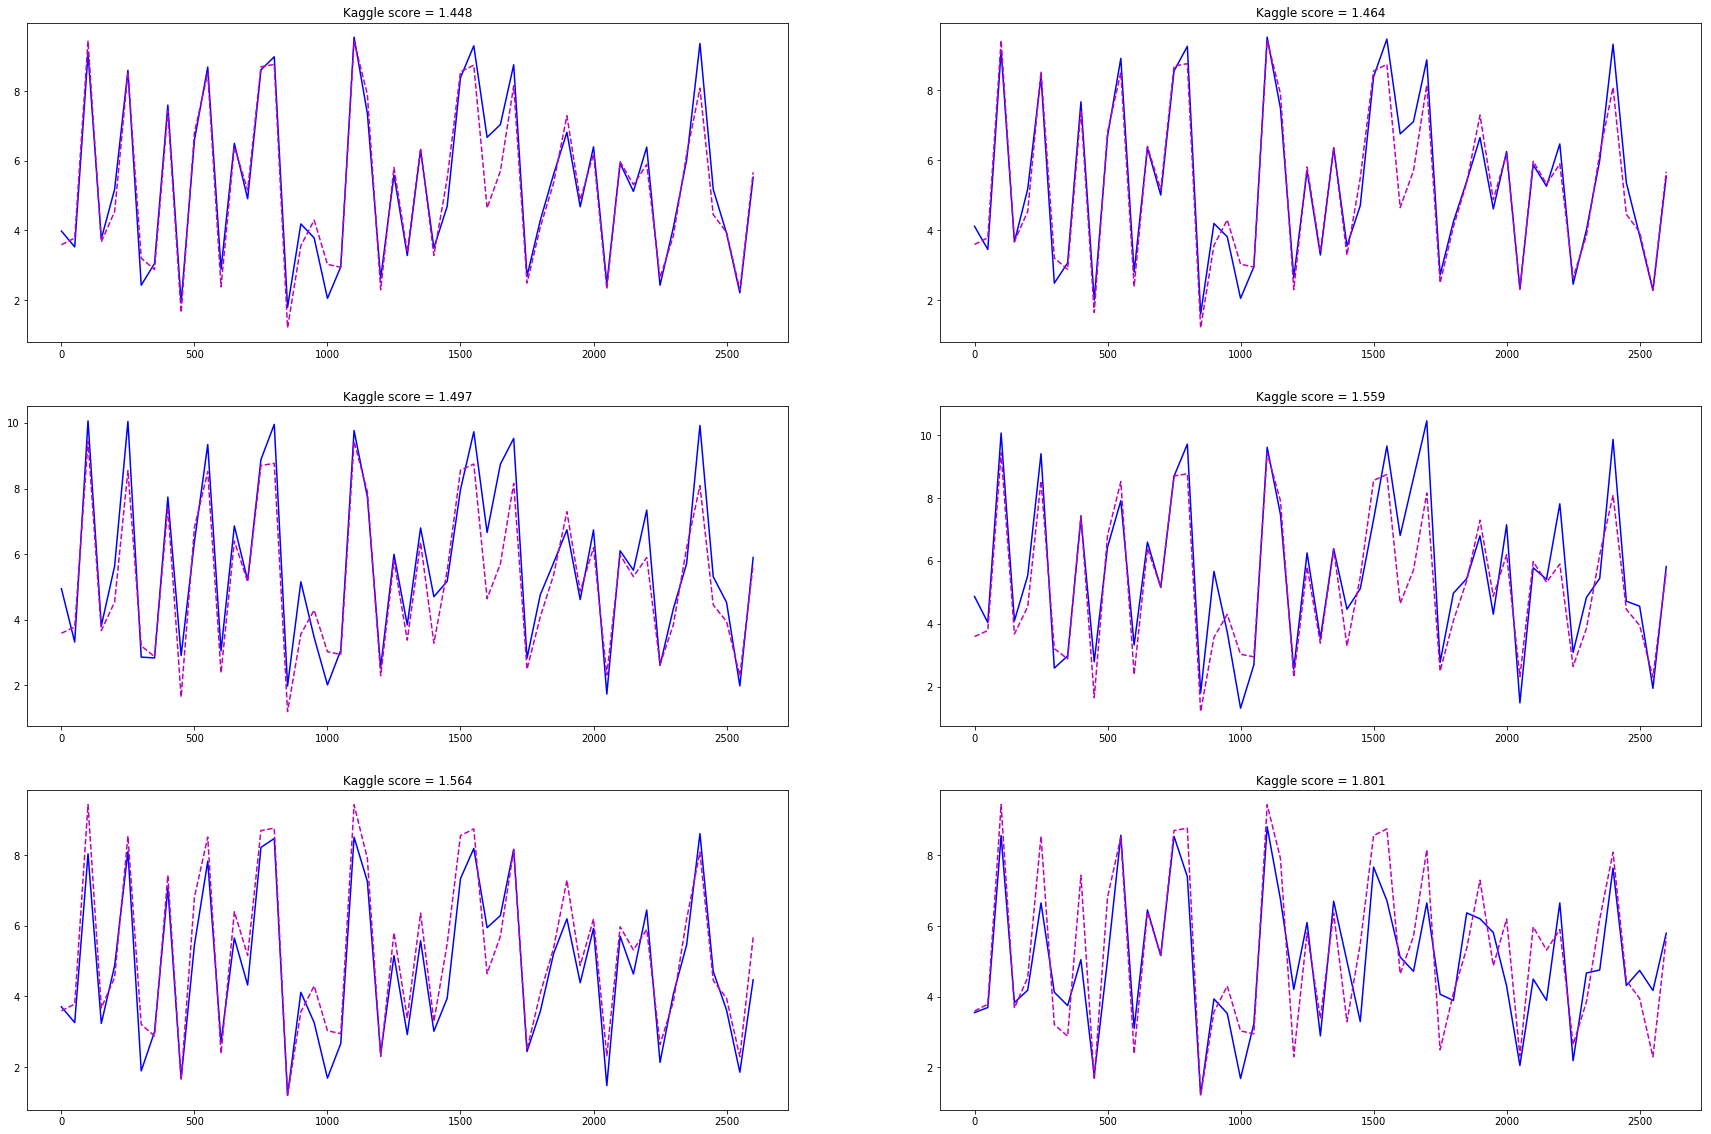

In [0]:
plt.figure(figsize=(30,20))

ax0 = plt.subplot2grid((3,2), (0,0), rowspan=1, colspan=1)
ax0.plot(df[36]['time_to_failure'][::50], 'b')
ax0.plot(preds_kaggle['time_to_failure'][::50], 'm--')
ax0.set_title('Kaggle score = 1.448')

ax1 = plt.subplot2grid((3,2), (0,1), rowspan=1, colspan=1)
ax1.plot(df[41]['time_to_failure'][::50], 'b')
ax1.plot(preds_kaggle['time_to_failure'][::50], 'm--')
ax1.set_title('Kaggle score = 1.464')

ax2 = plt.subplot2grid((3,2), (1,0), rowspan=1, colspan=1)
ax2.plot(df[28]['time_to_failure'][::50], 'b')
ax2.plot(preds_kaggle['time_to_failure'][::50], 'm--')
ax2.set_title('Kaggle score = 1.497')

ax3 = plt.subplot2grid((3,2), (1,1), rowspan=1, colspan=1)
ax3.plot(df[31]['time_to_failure'][::50], 'b')
ax3.plot(preds_kaggle['time_to_failure'][::50], 'm--')
ax3.set_title('Kaggle score = 1.559')

ax4 = plt.subplot2grid((3,2), (2,0), rowspan=1, colspan=1)
ax4.plot(df[37]['time_to_failure'][::50], 'b')
ax4.plot(preds_kaggle['time_to_failure'][::50], 'm--')
ax4.set_title('Kaggle score = 1.564')

ax5 = plt.subplot2grid((3,2), (2,1), rowspan=1, colspan=1)
ax5.plot(df[34]['time_to_failure'][::50], 'b')
ax5.plot(preds_kaggle['time_to_failure'][::50], 'm--')
ax5.set_title('Kaggle score = 1.801')

plt.show()

### Save model to CSV

In [0]:
# pred_df_1.to_csv('/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/submission_1.csv')
# pred_df_2.to_csv('/content/submission_2b.csv')
# pred_df_3.to_csv('/content/submission_3.csv')
# pred_df_4.to_csv('/content/submission_4.csv')
# pred_df_5.to_csv('/content/submission_5.csv')
# pred_df_6.to_csv('/content/submission_6.csv')
# pred_df_6.to_csv('/content/submission_61.csv')
# pred_df_7.to_csv('/content/submission_7.csv')
# pred_df_8.to_csv('/content/submission_8.csv')
# pred_df_9.to_csv('/content/submission_9.csv')
# pred_df_dl_32.to_csv('/content/submission_10.csv')
# pred_df_rf_4.to_csv('/content/submission_11.csv')
# pred_rf_5.to_csv('/content/submission_12.csv')
# pred_rf_6.to_csv('/content/submission_13.csv')
# pred_rf_7.to_csv('/content/submission_14.csv')
# pred_lgb_1.to_csv('/content/submission_15.csv')
# pred_cat_1.to_csv('/content/submission_16.csv')
# pred_lgb_2.to_csv('/content/submission_17.csv')
# pred_lgb_2.to_csv('/content/submission_18.csv')
# pred_lgb_3.to_csv('/content/submission_19.csv')
# pred_lgb_4.to_csv('/content/submission_20.csv')
# pred_lgb_5.to_csv('/content/submission_21.csv', index=False)
# df.to_csv('/content/submission_22.csv', index=False)
# pred_lgb_6.to_csv('/content/submission_24.csv', index=False)
# df.to_csv('/content/submission_25.csv', index=False)
# preds_kaggle.to_csv('/content/submission_26.csv', index=False)
# preds_kaggle.to_csv('/content/submission_27.csv', index=False)
# df.to_csv('/content/submission_28.csv', index=False)
# preds_kaggle.to_csv('/content/submission_29.csv', index=False)
# preds_kaggle.to_csv('/content/submission_30.csv', index=False)
# preds_kaggle.to_csv('/content/submission_32.csv', index=False)
# preds_kaggle.to_csv('/content/submission_33.csv', index=False)
# preds_kaggle.to_csv('/content/submission_34.csv', index=False)
# preds_kaggle.to_csv('/content/submission_35.csv', index=False)
# preds_kaggle.to_csv('/content/submission_36.csv', index=False)
# preds_kaggle.to_csv('/content/submission_37.csv', index=False)
# preds_kaggle.to_csv('/content/submission_38.csv', index=False)
# preds_kaggle.to_csv('/content/submission_39.csv', index=False)
# preds_kaggle.to_csv('/content/submission_40.csv', index=False)
# preds_kaggle.to_csv('/content/submission_41.csv', index=False)
# preds_kaggle.to_csv('/content/submission_42.csv', index=False)
# preds_kaggle.to_csv('/content/submission_43.csv', index=False)
# preds_kaggle.to_csv('/content/submission_44.csv', index=False)
preds_kaggle.to_csv('/content/submission_45.csv', index=False)


# Kaggle Submission

In [0]:
!ls '/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/submissions/submission_1.csv'

In [0]:
# !kaggle competitions submit -c LANL-Earthquake-Prediction -f '/content/gdrive/My Drive/Colab Notebooks/data1/LANL Earthquake/submissions/submission_1.csv' -m "model_1"

!kaggle competitions submit -c LANL-Earthquake-Prediction -f '/content/submission_31.csv' -m "LightGBM Model ([cols_lgbm_cat])"